In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 1576)
(1079604, 3)
validation
(190293, 1576)
(190293, 3)
test
(137379, 1576)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 2304259 (8.79 MB)


Trainable params: 2304259 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:09 - loss: 1.3306 - STD: 0.1814 - MAE: 0.4453

  4/108 [>.............................] - ETA: 2s - loss: 1.1992 - STD: 0.1219 - MAE: 0.4451  

  6/108 [>.............................] - ETA: 2s - loss: 1.1786 - STD: 0.1091 - MAE: 0.4451

  8/108 [=>............................] - ETA: 2s - loss: 1.1606 - STD: 0.0917 - MAE: 0.4450

 10/108 [=>............................] - ETA: 2s - loss: 1.1550 - STD: 0.0898 - MAE: 0.4450

 12/108 [==>...........................] - ETA: 2s - loss: 1.1494 - STD: 0.0869 - MAE: 0.4449

 14/108 [==>...........................] - ETA: 2s - loss: 1.1424 - STD: 0.0779 - MAE: 0.4448

 16/108 [===>..........................] - ETA: 2s - loss: 1.1374 - STD: 0.0717 - MAE: 0.4447

 18/108 [====>.........................] - ETA: 2s - loss: 1.1342 - STD: 0.0691 - MAE: 0.4447

 20/108 [====>.........................] - ETA: 2s - loss: 1.1314 - STD: 0.0666 - MAE: 0.4446

 22/108 [=====>........................] - ETA: 2s - loss: 1.1285 - STD: 0.0623 - MAE: 0.4446

 24/108 [=====>........................] - ETA: 2s - loss: 1.1261 - STD: 0.0582 - MAE: 0.4446

 26/108 [======>.......................] - ETA: 2s - loss: 1.1241 - STD: 0.0559 - MAE: 0.4445

 28/108 [======>.......................] - ETA: 2s - loss: 1.1225 - STD: 0.0538 - MAE: 0.4445

 30/108 [=======>......................] - ETA: 2s - loss: 1.1210 - STD: 0.0511 - MAE: 0.4445

 32/108 [=======>......................] - ETA: 2s - loss: 1.1195 - STD: 0.0483 - MAE: 0.4445

 34/108 [========>.....................] - ETA: 2s - loss: 1.1183 - STD: 0.0465 - MAE: 0.4445

 36/108 [=========>....................] - ETA: 2s - loss: 1.1173 - STD: 0.0450 - MAE: 0.4445

 38/108 [=========>....................] - ETA: 2s - loss: 1.1163 - STD: 0.0432 - MAE: 0.4445

 40/108 [==========>...................] - ETA: 2s - loss: 1.1154 - STD: 0.0416 - MAE: 0.4445

 42/108 [==========>...................] - ETA: 2s - loss: 1.1146 - STD: 0.0404 - MAE: 0.4444

 44/108 [===========>..................] - ETA: 2s - loss: 1.1139 - STD: 0.0393 - MAE: 0.4444

 46/108 [===========>..................] - ETA: 1s - loss: 1.1132 - STD: 0.0378 - MAE: 0.4444

 48/108 [============>.................] - ETA: 1s - loss: 1.1126 - STD: 0.0368 - MAE: 0.4444

 50/108 [============>.................] - ETA: 1s - loss: 1.1120 - STD: 0.0360 - MAE: 0.4444

 52/108 [=============>................] - ETA: 1s - loss: 1.1114 - STD: 0.0351 - MAE: 0.4444

 54/108 [==============>...............] - ETA: 1s - loss: 1.1108 - STD: 0.0340 - MAE: 0.4444

 56/108 [==============>...............] - ETA: 1s - loss: 1.1103 - STD: 0.0331 - MAE: 0.4443

 57/108 [==============>...............] - ETA: 2s - loss: 1.1101 - STD: 0.0328 - MAE: 0.4443

 60/108 [===============>..............] - ETA: 2s - loss: 1.1093 - STD: 0.0315 - MAE: 0.4443

 63/108 [================>.............] - ETA: 1s - loss: 1.1086 - STD: 0.0303 - MAE: 0.4442

 65/108 [=================>............] - ETA: 1s - loss: 1.1081 - STD: 0.0296 - MAE: 0.4442

 67/108 [=================>............] - ETA: 1s - loss: 1.1076 - STD: 0.0289 - MAE: 0.4442

 69/108 [==================>...........] - ETA: 1s - loss: 1.1071 - STD: 0.0283 - MAE: 0.4441

 71/108 [==================>...........] - ETA: 1s - loss: 1.1065 - STD: 0.0278 - MAE: 0.4441

 73/108 [===================>..........] - ETA: 1s - loss: 1.1060 - STD: 0.0273 - MAE: 0.4440

 75/108 [===================>..........] - ETA: 1s - loss: 1.1053 - STD: 0.0269 - MAE: 0.4439

 77/108 [====================>.........] - ETA: 1s - loss: 1.1046 - STD: 0.0265 - MAE: 0.4438

 79/108 [====================>.........] - ETA: 1s - loss: 1.1038 - STD: 0.0263 - MAE: 0.4437

 81/108 [=====================>........] - ETA: 1s - loss: 1.1029 - STD: 0.0263 - MAE: 0.4435

 83/108 [======================>.......] - ETA: 0s - loss: 1.1017 - STD: 0.0264 - MAE: 0.4432

 85/108 [======================>.......] - ETA: 0s - loss: 1.1003 - STD: 0.0267 - MAE: 0.4429

 87/108 [=======================>......] - ETA: 0s - loss: 1.0987 - STD: 0.0273 - MAE: 0.4425

 89/108 [=======================>......] - ETA: 0s - loss: 1.0967 - STD: 0.0283 - MAE: 0.4420

 91/108 [========================>.....] - ETA: 0s - loss: 1.0944 - STD: 0.0297 - MAE: 0.4414

 93/108 [========================>.....] - ETA: 0s - loss: 1.0920 - STD: 0.0314 - MAE: 0.4406

 95/108 [=========================>....] - ETA: 0s - loss: 1.0893 - STD: 0.0336 - MAE: 0.4397

 97/108 [=========================>....] - ETA: 0s - loss: 1.0866 - STD: 0.0359 - MAE: 0.4388

 99/108 [==========================>...] - ETA: 0s - loss: 1.0838 - STD: 0.0383 - MAE: 0.4377

101/108 [===========================>..] - ETA: 0s - loss: 1.0809 - STD: 0.0409 - MAE: 0.4365

103/108 [===========================>..] - ETA: 0s - loss: 1.0780 - STD: 0.0435 - MAE: 0.4354

105/108 [============================>.] - ETA: 0s - loss: 1.0750 - STD: 0.0461 - MAE: 0.4342

107/108 [============================>.] - ETA: 0s - loss: 1.0722 - STD: 0.0486 - MAE: 0.4330

108/108 [==============================] - 6s 49ms/step - loss: 1.0707 - STD: 0.0498 - MAE: 0.4325 - val_loss: 0.9212 - val_STD: 0.1765 - val_MAE: 0.3704


Epoch 2/10000


  1/108 [..............................] - ETA: 6s - loss: 0.9155 - STD: 0.1793 - MAE: 0.3713

  3/108 [..............................] - ETA: 3s - loss: 0.9131 - STD: 0.1815 - MAE: 0.3704

  5/108 [>.............................] - ETA: 3s - loss: 0.9103 - STD: 0.1825 - MAE: 0.3694

  7/108 [>.............................] - ETA: 3s - loss: 0.9069 - STD: 0.1843 - MAE: 0.3681

  9/108 [=>............................] - ETA: 3s - loss: 0.9037 - STD: 0.1871 - MAE: 0.3664

 11/108 [==>...........................] - ETA: 3s - loss: 0.9013 - STD: 0.1894 - MAE: 0.3649

 13/108 [==>...........................] - ETA: 3s - loss: 0.9014 - STD: 0.1920 - MAE: 0.3639

 15/108 [===>..........................] - ETA: 3s - loss: 0.9002 - STD: 0.1941 - MAE: 0.3628

 17/108 [===>..........................] - ETA: 3s - loss: 0.8980 - STD: 0.1954 - MAE: 0.3619

 19/108 [====>.........................] - ETA: 2s - loss: 0.8963 - STD: 0.1960 - MAE: 0.3613

 21/108 [====>.........................] - ETA: 2s - loss: 0.8941 - STD: 0.1968 - MAE: 0.3605

 23/108 [=====>........................] - ETA: 2s - loss: 0.8917 - STD: 0.1980 - MAE: 0.3595

 25/108 [=====>........................] - ETA: 2s - loss: 0.8896 - STD: 0.1995 - MAE: 0.3585

 27/108 [======>.......................] - ETA: 2s - loss: 0.8875 - STD: 0.2009 - MAE: 0.3574

 29/108 [=======>......................] - ETA: 2s - loss: 0.8865 - STD: 0.2024 - MAE: 0.3566

 31/108 [=======>......................] - ETA: 2s - loss: 0.8860 - STD: 0.2040 - MAE: 0.3558

 33/108 [========>.....................] - ETA: 2s - loss: 0.8842 - STD: 0.2049 - MAE: 0.3550

 35/108 [========>.....................] - ETA: 2s - loss: 0.8827 - STD: 0.2058 - MAE: 0.3544

 37/108 [=========>....................] - ETA: 2s - loss: 0.8804 - STD: 0.2067 - MAE: 0.3535

 39/108 [=========>....................] - ETA: 2s - loss: 0.8785 - STD: 0.2075 - MAE: 0.3527

 41/108 [==========>...................] - ETA: 2s - loss: 0.8766 - STD: 0.2083 - MAE: 0.3520

 43/108 [==========>...................] - ETA: 2s - loss: 0.8752 - STD: 0.2091 - MAE: 0.3513

 45/108 [===========>..................] - ETA: 2s - loss: 0.8736 - STD: 0.2101 - MAE: 0.3506

 47/108 [============>.................] - ETA: 2s - loss: 0.8722 - STD: 0.2110 - MAE: 0.3499

 49/108 [============>.................] - ETA: 1s - loss: 0.8719 - STD: 0.2119 - MAE: 0.3494

 51/108 [=============>................] - ETA: 1s - loss: 0.8712 - STD: 0.2126 - MAE: 0.3490

 53/108 [=============>................] - ETA: 1s - loss: 0.8711 - STD: 0.2134 - MAE: 0.3486

 55/108 [==============>...............] - ETA: 1s - loss: 0.8705 - STD: 0.2143 - MAE: 0.3481

 57/108 [==============>...............] - ETA: 1s - loss: 0.8698 - STD: 0.2146 - MAE: 0.3478

 59/108 [===============>..............] - ETA: 1s - loss: 0.8689 - STD: 0.2153 - MAE: 0.3473

 61/108 [===============>..............] - ETA: 1s - loss: 0.8680 - STD: 0.2157 - MAE: 0.3469

 63/108 [================>.............] - ETA: 1s - loss: 0.8674 - STD: 0.2163 - MAE: 0.3466

 65/108 [=================>............] - ETA: 1s - loss: 0.8668 - STD: 0.2168 - MAE: 0.3462

 67/108 [=================>............] - ETA: 1s - loss: 0.8660 - STD: 0.2172 - MAE: 0.3459

 69/108 [==================>...........] - ETA: 1s - loss: 0.8651 - STD: 0.2177 - MAE: 0.3455

 71/108 [==================>...........] - ETA: 1s - loss: 0.8641 - STD: 0.2180 - MAE: 0.3451

 73/108 [===================>..........] - ETA: 1s - loss: 0.8631 - STD: 0.2186 - MAE: 0.3446

 75/108 [===================>..........] - ETA: 1s - loss: 0.8618 - STD: 0.2190 - MAE: 0.3442

 77/108 [====================>.........] - ETA: 1s - loss: 0.8609 - STD: 0.2196 - MAE: 0.3437

 79/108 [====================>.........] - ETA: 0s - loss: 0.8598 - STD: 0.2201 - MAE: 0.3433

 81/108 [=====================>........] - ETA: 0s - loss: 0.8587 - STD: 0.2207 - MAE: 0.3427

 83/108 [======================>.......] - ETA: 0s - loss: 0.8575 - STD: 0.2212 - MAE: 0.3422

 85/108 [======================>.......] - ETA: 0s - loss: 0.8564 - STD: 0.2218 - MAE: 0.3417

 87/108 [=======================>......] - ETA: 0s - loss: 0.8554 - STD: 0.2223 - MAE: 0.3413

 89/108 [=======================>......] - ETA: 0s - loss: 0.8545 - STD: 0.2228 - MAE: 0.3408

 91/108 [========================>.....] - ETA: 0s - loss: 0.8539 - STD: 0.2233 - MAE: 0.3405

 93/108 [========================>.....] - ETA: 0s - loss: 0.8530 - STD: 0.2238 - MAE: 0.3401

 95/108 [=========================>....] - ETA: 0s - loss: 0.8524 - STD: 0.2243 - MAE: 0.3397

 97/108 [=========================>....] - ETA: 0s - loss: 0.8516 - STD: 0.2246 - MAE: 0.3394

 99/108 [==========================>...] - ETA: 0s - loss: 0.8509 - STD: 0.2251 - MAE: 0.3390

101/108 [===========================>..] - ETA: 0s - loss: 0.8501 - STD: 0.2254 - MAE: 0.3387

103/108 [===========================>..] - ETA: 0s - loss: 0.8493 - STD: 0.2257 - MAE: 0.3384

105/108 [============================>.] - ETA: 0s - loss: 0.8484 - STD: 0.2261 - MAE: 0.3380

107/108 [============================>.] - ETA: 0s - loss: 0.8477 - STD: 0.2265 - MAE: 0.3377

108/108 [==============================] - 4s 40ms/step - loss: 0.8473 - STD: 0.2267 - MAE: 0.3375 - val_loss: 0.8434 - val_STD: 0.2551 - val_MAE: 0.3196


Epoch 3/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7965 - STD: 0.2484 - MAE: 0.3164

  3/108 [..............................] - ETA: 3s - loss: 0.7977 - STD: 0.2495 - MAE: 0.3163

  5/108 [>.............................] - ETA: 3s - loss: 0.8001 - STD: 0.2497 - MAE: 0.3167

  7/108 [>.............................] - ETA: 3s - loss: 0.7994 - STD: 0.2503 - MAE: 0.3162

  9/108 [=>............................] - ETA: 3s - loss: 0.7999 - STD: 0.2505 - MAE: 0.3161

 11/108 [==>...........................] - ETA: 3s - loss: 0.8005 - STD: 0.2508 - MAE: 0.3161

 13/108 [==>...........................] - ETA: 3s - loss: 0.8010 - STD: 0.2508 - MAE: 0.3163

 15/108 [===>..........................] - ETA: 3s - loss: 0.8008 - STD: 0.2509 - MAE: 0.3163

 17/108 [===>..........................] - ETA: 2s - loss: 0.8007 - STD: 0.2509 - MAE: 0.3162

 19/108 [====>.........................] - ETA: 2s - loss: 0.8007 - STD: 0.2509 - MAE: 0.3162

 21/108 [====>.........................] - ETA: 2s - loss: 0.8001 - STD: 0.2513 - MAE: 0.3159

 23/108 [=====>........................] - ETA: 2s - loss: 0.8009 - STD: 0.2515 - MAE: 0.3160

 25/108 [=====>........................] - ETA: 2s - loss: 0.8027 - STD: 0.2519 - MAE: 0.3162

 27/108 [======>.......................] - ETA: 2s - loss: 0.8033 - STD: 0.2516 - MAE: 0.3165

 29/108 [=======>......................] - ETA: 2s - loss: 0.8061 - STD: 0.2522 - MAE: 0.3168

 31/108 [=======>......................] - ETA: 2s - loss: 0.8078 - STD: 0.2526 - MAE: 0.3170

 33/108 [========>.....................] - ETA: 2s - loss: 0.8084 - STD: 0.2516 - MAE: 0.3176

 35/108 [========>.....................] - ETA: 2s - loss: 0.8081 - STD: 0.2514 - MAE: 0.3177

 37/108 [=========>....................] - ETA: 2s - loss: 0.8078 - STD: 0.2507 - MAE: 0.3180

 39/108 [=========>....................] - ETA: 2s - loss: 0.8076 - STD: 0.2506 - MAE: 0.3180

 41/108 [==========>...................] - ETA: 2s - loss: 0.8076 - STD: 0.2504 - MAE: 0.3181

 43/108 [==========>...................] - ETA: 2s - loss: 0.8073 - STD: 0.2504 - MAE: 0.3180

 45/108 [===========>..................] - ETA: 2s - loss: 0.8068 - STD: 0.2505 - MAE: 0.3179

 47/108 [============>.................] - ETA: 2s - loss: 0.8067 - STD: 0.2505 - MAE: 0.3178

 49/108 [============>.................] - ETA: 1s - loss: 0.8061 - STD: 0.2507 - MAE: 0.3176

 51/108 [=============>................] - ETA: 1s - loss: 0.8057 - STD: 0.2509 - MAE: 0.3174

 53/108 [=============>................] - ETA: 1s - loss: 0.8051 - STD: 0.2511 - MAE: 0.3172

 55/108 [==============>...............] - ETA: 1s - loss: 0.8046 - STD: 0.2514 - MAE: 0.3169

 57/108 [==============>...............] - ETA: 1s - loss: 0.8042 - STD: 0.2516 - MAE: 0.3167

 59/108 [===============>..............] - ETA: 1s - loss: 0.8033 - STD: 0.2518 - MAE: 0.3164

 61/108 [===============>..............] - ETA: 1s - loss: 0.8028 - STD: 0.2520 - MAE: 0.3162

 63/108 [================>.............] - ETA: 1s - loss: 0.8022 - STD: 0.2522 - MAE: 0.3160

 65/108 [=================>............] - ETA: 1s - loss: 0.8014 - STD: 0.2523 - MAE: 0.3158

 67/108 [=================>............] - ETA: 1s - loss: 0.8011 - STD: 0.2525 - MAE: 0.3156

 69/108 [==================>...........] - ETA: 1s - loss: 0.8006 - STD: 0.2527 - MAE: 0.3155

 71/108 [==================>...........] - ETA: 1s - loss: 0.8001 - STD: 0.2527 - MAE: 0.3153

 73/108 [===================>..........] - ETA: 1s - loss: 0.7996 - STD: 0.2528 - MAE: 0.3152

 75/108 [===================>..........] - ETA: 1s - loss: 0.7990 - STD: 0.2529 - MAE: 0.3150

 77/108 [====================>.........] - ETA: 1s - loss: 0.7986 - STD: 0.2531 - MAE: 0.3148

 79/108 [====================>.........] - ETA: 0s - loss: 0.7980 - STD: 0.2534 - MAE: 0.3146

 81/108 [=====================>........] - ETA: 0s - loss: 0.7975 - STD: 0.2535 - MAE: 0.3144

 83/108 [======================>.......] - ETA: 0s - loss: 0.7971 - STD: 0.2537 - MAE: 0.3142

 85/108 [======================>.......] - ETA: 0s - loss: 0.7976 - STD: 0.2539 - MAE: 0.3142

 87/108 [=======================>......] - ETA: 0s - loss: 0.7977 - STD: 0.2541 - MAE: 0.3142

 89/108 [=======================>......] - ETA: 0s - loss: 0.7979 - STD: 0.2542 - MAE: 0.3142

 91/108 [========================>.....] - ETA: 0s - loss: 0.7985 - STD: 0.2546 - MAE: 0.3141

 93/108 [========================>.....] - ETA: 0s - loss: 0.8003 - STD: 0.2549 - MAE: 0.3143

 95/108 [=========================>....] - ETA: 0s - loss: 0.8013 - STD: 0.2552 - MAE: 0.3144

 97/108 [=========================>....] - ETA: 0s - loss: 0.8017 - STD: 0.2550 - MAE: 0.3145

 99/108 [==========================>...] - ETA: 0s - loss: 0.8024 - STD: 0.2551 - MAE: 0.3147

101/108 [===========================>..] - ETA: 0s - loss: 0.8028 - STD: 0.2547 - MAE: 0.3150

103/108 [===========================>..] - ETA: 0s - loss: 0.8027 - STD: 0.2545 - MAE: 0.3151

105/108 [============================>.] - ETA: 0s - loss: 0.8028 - STD: 0.2542 - MAE: 0.3152

107/108 [============================>.] - ETA: 0s - loss: 0.8029 - STD: 0.2540 - MAE: 0.3153

108/108 [==============================] - 4s 39ms/step - loss: 0.8028 - STD: 0.2539 - MAE: 0.3153 - val_loss: 0.8246 - val_STD: 0.2668 - val_MAE: 0.3111


Epoch 4/10000


  1/108 [..............................] - ETA: 8s - loss: 0.8011 - STD: 0.2521 - MAE: 0.3166

  3/108 [..............................] - ETA: 3s - loss: 0.7992 - STD: 0.2520 - MAE: 0.3160

  5/108 [>.............................] - ETA: 3s - loss: 0.7973 - STD: 0.2502 - MAE: 0.3162

  7/108 [>.............................] - ETA: 3s - loss: 0.7953 - STD: 0.2525 - MAE: 0.3147

  9/108 [=>............................] - ETA: 3s - loss: 0.7933 - STD: 0.2534 - MAE: 0.3138

 11/108 [==>...........................] - ETA: 3s - loss: 0.7906 - STD: 0.2535 - MAE: 0.3130

 13/108 [==>...........................] - ETA: 3s - loss: 0.7906 - STD: 0.2547 - MAE: 0.3125

 15/108 [===>..........................] - ETA: 3s - loss: 0.7886 - STD: 0.2549 - MAE: 0.3119

 17/108 [===>..........................] - ETA: 3s - loss: 0.7880 - STD: 0.2552 - MAE: 0.3116

 19/108 [====>.........................] - ETA: 2s - loss: 0.7873 - STD: 0.2554 - MAE: 0.3113

 21/108 [====>.........................] - ETA: 2s - loss: 0.7853 - STD: 0.2554 - MAE: 0.3109

 23/108 [=====>........................] - ETA: 2s - loss: 0.7840 - STD: 0.2558 - MAE: 0.3104

 25/108 [=====>........................] - ETA: 2s - loss: 0.7832 - STD: 0.2558 - MAE: 0.3103

 27/108 [======>.......................] - ETA: 2s - loss: 0.7825 - STD: 0.2561 - MAE: 0.3100

 29/108 [=======>......................] - ETA: 2s - loss: 0.7814 - STD: 0.2566 - MAE: 0.3095

 31/108 [=======>......................] - ETA: 2s - loss: 0.7802 - STD: 0.2571 - MAE: 0.3090

 33/108 [========>.....................] - ETA: 2s - loss: 0.7797 - STD: 0.2575 - MAE: 0.3087

 35/108 [========>.....................] - ETA: 2s - loss: 0.7787 - STD: 0.2579 - MAE: 0.3083

 37/108 [=========>....................] - ETA: 2s - loss: 0.7782 - STD: 0.2582 - MAE: 0.3080

 39/108 [=========>....................] - ETA: 2s - loss: 0.7775 - STD: 0.2585 - MAE: 0.3077

 41/108 [==========>...................] - ETA: 2s - loss: 0.7772 - STD: 0.2589 - MAE: 0.3074

 43/108 [==========>...................] - ETA: 2s - loss: 0.7767 - STD: 0.2593 - MAE: 0.3072

 45/108 [===========>..................] - ETA: 2s - loss: 0.7765 - STD: 0.2597 - MAE: 0.3069

 47/108 [============>.................] - ETA: 1s - loss: 0.7765 - STD: 0.2601 - MAE: 0.3067

 49/108 [============>.................] - ETA: 1s - loss: 0.7762 - STD: 0.2603 - MAE: 0.3065

 51/108 [=============>................] - ETA: 1s - loss: 0.7762 - STD: 0.2607 - MAE: 0.3063

 53/108 [=============>................] - ETA: 1s - loss: 0.7760 - STD: 0.2608 - MAE: 0.3063

 55/108 [==============>...............] - ETA: 1s - loss: 0.7759 - STD: 0.2609 - MAE: 0.3062

 57/108 [==============>...............] - ETA: 1s - loss: 0.7758 - STD: 0.2610 - MAE: 0.3061

 59/108 [===============>..............] - ETA: 1s - loss: 0.7758 - STD: 0.2610 - MAE: 0.3061

 61/108 [===============>..............] - ETA: 1s - loss: 0.7757 - STD: 0.2613 - MAE: 0.3060

 63/108 [================>.............] - ETA: 1s - loss: 0.7756 - STD: 0.2613 - MAE: 0.3059

 65/108 [=================>............] - ETA: 1s - loss: 0.7753 - STD: 0.2614 - MAE: 0.3058

 67/108 [=================>............] - ETA: 1s - loss: 0.7750 - STD: 0.2614 - MAE: 0.3057

 69/108 [==================>...........] - ETA: 1s - loss: 0.7746 - STD: 0.2616 - MAE: 0.3056

 71/108 [==================>...........] - ETA: 1s - loss: 0.7743 - STD: 0.2617 - MAE: 0.3055

 73/108 [===================>..........] - ETA: 1s - loss: 0.7739 - STD: 0.2617 - MAE: 0.3053

 75/108 [===================>..........] - ETA: 1s - loss: 0.7736 - STD: 0.2619 - MAE: 0.3052

 77/108 [====================>.........] - ETA: 1s - loss: 0.7734 - STD: 0.2620 - MAE: 0.3051

 79/108 [====================>.........] - ETA: 0s - loss: 0.7727 - STD: 0.2622 - MAE: 0.3049

 81/108 [=====================>........] - ETA: 0s - loss: 0.7726 - STD: 0.2624 - MAE: 0.3047

 83/108 [======================>.......] - ETA: 0s - loss: 0.7723 - STD: 0.2626 - MAE: 0.3046

 85/108 [======================>.......] - ETA: 0s - loss: 0.7720 - STD: 0.2627 - MAE: 0.3044

 87/108 [=======================>......] - ETA: 0s - loss: 0.7721 - STD: 0.2628 - MAE: 0.3044

 89/108 [=======================>......] - ETA: 0s - loss: 0.7721 - STD: 0.2629 - MAE: 0.3044

 91/108 [========================>.....] - ETA: 0s - loss: 0.7720 - STD: 0.2631 - MAE: 0.3042

 93/108 [========================>.....] - ETA: 0s - loss: 0.7718 - STD: 0.2632 - MAE: 0.3041

 95/108 [=========================>....] - ETA: 0s - loss: 0.7720 - STD: 0.2634 - MAE: 0.3041

 97/108 [=========================>....] - ETA: 0s - loss: 0.7717 - STD: 0.2635 - MAE: 0.3040

 99/108 [==========================>...] - ETA: 0s - loss: 0.7718 - STD: 0.2636 - MAE: 0.3039

101/108 [===========================>..] - ETA: 0s - loss: 0.7717 - STD: 0.2637 - MAE: 0.3039

103/108 [===========================>..] - ETA: 0s - loss: 0.7718 - STD: 0.2638 - MAE: 0.3039

105/108 [============================>.] - ETA: 0s - loss: 0.7715 - STD: 0.2639 - MAE: 0.3037

107/108 [============================>.] - ETA: 0s - loss: 0.7714 - STD: 0.2639 - MAE: 0.3037

108/108 [==============================] - 4s 38ms/step - loss: 0.7714 - STD: 0.2640 - MAE: 0.3037 - val_loss: 0.8078 - val_STD: 0.2740 - val_MAE: 0.3042


Epoch 5/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7509 - STD: 0.2603 - MAE: 0.3014

  3/108 [..............................] - ETA: 3s - loss: 0.7633 - STD: 0.2635 - MAE: 0.3026

  5/108 [>.............................] - ETA: 3s - loss: 0.7633 - STD: 0.2640 - MAE: 0.3022

  7/108 [>.............................] - ETA: 3s - loss: 0.7658 - STD: 0.2649 - MAE: 0.3023

  9/108 [=>............................] - ETA: 3s - loss: 0.7646 - STD: 0.2653 - MAE: 0.3018

 11/108 [==>...........................] - ETA: 3s - loss: 0.7636 - STD: 0.2659 - MAE: 0.3013

 13/108 [==>...........................] - ETA: 3s - loss: 0.7650 - STD: 0.2661 - MAE: 0.3015

 15/108 [===>..........................] - ETA: 3s - loss: 0.7633 - STD: 0.2662 - MAE: 0.3010

 17/108 [===>..........................] - ETA: 3s - loss: 0.7627 - STD: 0.2667 - MAE: 0.3007

 19/108 [====>.........................] - ETA: 2s - loss: 0.7627 - STD: 0.2667 - MAE: 0.3006

 21/108 [====>.........................] - ETA: 2s - loss: 0.7621 - STD: 0.2674 - MAE: 0.3002

 23/108 [=====>........................] - ETA: 2s - loss: 0.7607 - STD: 0.2677 - MAE: 0.2997

 25/108 [=====>........................] - ETA: 2s - loss: 0.7611 - STD: 0.2678 - MAE: 0.2997

 27/108 [======>.......................] - ETA: 2s - loss: 0.7609 - STD: 0.2680 - MAE: 0.2996

 29/108 [=======>......................] - ETA: 2s - loss: 0.7609 - STD: 0.2680 - MAE: 0.2996

 31/108 [=======>......................] - ETA: 2s - loss: 0.7618 - STD: 0.2683 - MAE: 0.2996

 33/108 [========>.....................] - ETA: 2s - loss: 0.7615 - STD: 0.2684 - MAE: 0.2995

 35/108 [========>.....................] - ETA: 2s - loss: 0.7610 - STD: 0.2685 - MAE: 0.2993

 37/108 [=========>....................] - ETA: 2s - loss: 0.7609 - STD: 0.2687 - MAE: 0.2992

 39/108 [=========>....................] - ETA: 2s - loss: 0.7601 - STD: 0.2687 - MAE: 0.2990

 41/108 [==========>...................] - ETA: 2s - loss: 0.7602 - STD: 0.2689 - MAE: 0.2990

 43/108 [==========>...................] - ETA: 2s - loss: 0.7601 - STD: 0.2689 - MAE: 0.2989

 45/108 [===========>..................] - ETA: 2s - loss: 0.7606 - STD: 0.2692 - MAE: 0.2988

 47/108 [============>.................] - ETA: 2s - loss: 0.7620 - STD: 0.2697 - MAE: 0.2989

 49/108 [============>.................] - ETA: 1s - loss: 0.7629 - STD: 0.2698 - MAE: 0.2990

 51/108 [=============>................] - ETA: 1s - loss: 0.7659 - STD: 0.2706 - MAE: 0.2991

 53/108 [=============>................] - ETA: 1s - loss: 0.7680 - STD: 0.2709 - MAE: 0.2995

 55/108 [==============>...............] - ETA: 1s - loss: 0.7688 - STD: 0.2710 - MAE: 0.2995

 57/108 [==============>...............] - ETA: 1s - loss: 0.7696 - STD: 0.2707 - MAE: 0.2999

 59/108 [===============>..............] - ETA: 1s - loss: 0.7699 - STD: 0.2705 - MAE: 0.3001

 61/108 [===============>..............] - ETA: 1s - loss: 0.7703 - STD: 0.2699 - MAE: 0.3005

 63/108 [================>.............] - ETA: 1s - loss: 0.7705 - STD: 0.2696 - MAE: 0.3007

 65/108 [=================>............] - ETA: 1s - loss: 0.7704 - STD: 0.2690 - MAE: 0.3009

 67/108 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2688 - MAE: 0.3010

 69/108 [==================>...........] - ETA: 1s - loss: 0.7697 - STD: 0.2685 - MAE: 0.3011

 71/108 [==================>...........] - ETA: 1s - loss: 0.7692 - STD: 0.2683 - MAE: 0.3011

 73/108 [===================>..........] - ETA: 1s - loss: 0.7687 - STD: 0.2682 - MAE: 0.3010

 75/108 [===================>..........] - ETA: 1s - loss: 0.7683 - STD: 0.2680 - MAE: 0.3010

 77/108 [====================>.........] - ETA: 1s - loss: 0.7680 - STD: 0.2680 - MAE: 0.3010

 79/108 [====================>.........] - ETA: 0s - loss: 0.7676 - STD: 0.2680 - MAE: 0.3009

 81/108 [=====================>........] - ETA: 0s - loss: 0.7672 - STD: 0.2680 - MAE: 0.3008

 83/108 [======================>.......] - ETA: 0s - loss: 0.7667 - STD: 0.2681 - MAE: 0.3006

 85/108 [======================>.......] - ETA: 0s - loss: 0.7664 - STD: 0.2682 - MAE: 0.3005

 87/108 [=======================>......] - ETA: 0s - loss: 0.7660 - STD: 0.2682 - MAE: 0.3004

 89/108 [=======================>......] - ETA: 0s - loss: 0.7656 - STD: 0.2684 - MAE: 0.3002

 91/108 [========================>.....] - ETA: 0s - loss: 0.7654 - STD: 0.2684 - MAE: 0.3002

 93/108 [========================>.....] - ETA: 0s - loss: 0.7651 - STD: 0.2685 - MAE: 0.3001

 95/108 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2686 - MAE: 0.3000

 97/108 [=========================>....] - ETA: 0s - loss: 0.7645 - STD: 0.2687 - MAE: 0.2998

 99/108 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2688 - MAE: 0.2998

101/108 [===========================>..] - ETA: 0s - loss: 0.7641 - STD: 0.2688 - MAE: 0.2997

103/108 [===========================>..] - ETA: 0s - loss: 0.7638 - STD: 0.2689 - MAE: 0.2996

105/108 [============================>.] - ETA: 0s - loss: 0.7638 - STD: 0.2690 - MAE: 0.2995

107/108 [============================>.] - ETA: 0s - loss: 0.7636 - STD: 0.2691 - MAE: 0.2995

108/108 [==============================] - 4s 39ms/step - loss: 0.7635 - STD: 0.2692 - MAE: 0.2994 - val_loss: 0.7942 - val_STD: 0.2918 - val_MAE: 0.2935


Epoch 6/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7473 - STD: 0.2774 - MAE: 0.2912

  3/108 [..............................] - ETA: 3s - loss: 0.7565 - STD: 0.2768 - MAE: 0.2937

  5/108 [>.............................] - ETA: 3s - loss: 0.7581 - STD: 0.2767 - MAE: 0.2943

  7/108 [>.............................] - ETA: 3s - loss: 0.7576 - STD: 0.2760 - MAE: 0.2946

  9/108 [=>............................] - ETA: 3s - loss: 0.7580 - STD: 0.2752 - MAE: 0.2951

 11/108 [==>...........................] - ETA: 3s - loss: 0.7568 - STD: 0.2745 - MAE: 0.2952

 13/108 [==>...........................] - ETA: 3s - loss: 0.7549 - STD: 0.2738 - MAE: 0.2951

 15/108 [===>..........................] - ETA: 3s - loss: 0.7540 - STD: 0.2732 - MAE: 0.2952

 17/108 [===>..........................] - ETA: 3s - loss: 0.7527 - STD: 0.2729 - MAE: 0.2951

 19/108 [====>.........................] - ETA: 2s - loss: 0.7523 - STD: 0.2729 - MAE: 0.2950

 21/108 [====>.........................] - ETA: 2s - loss: 0.7526 - STD: 0.2729 - MAE: 0.2951

 23/108 [=====>........................] - ETA: 2s - loss: 0.7525 - STD: 0.2728 - MAE: 0.2951

 25/108 [=====>........................] - ETA: 2s - loss: 0.7521 - STD: 0.2729 - MAE: 0.2950

 27/108 [======>.......................] - ETA: 2s - loss: 0.7519 - STD: 0.2729 - MAE: 0.2949

 29/108 [=======>......................] - ETA: 2s - loss: 0.7510 - STD: 0.2728 - MAE: 0.2948

 31/108 [=======>......................] - ETA: 2s - loss: 0.7505 - STD: 0.2727 - MAE: 0.2947

 33/108 [========>.....................] - ETA: 2s - loss: 0.7503 - STD: 0.2727 - MAE: 0.2947

 35/108 [========>.....................] - ETA: 2s - loss: 0.7508 - STD: 0.2729 - MAE: 0.2947

 37/108 [=========>....................] - ETA: 2s - loss: 0.7517 - STD: 0.2733 - MAE: 0.2947

 39/108 [=========>....................] - ETA: 2s - loss: 0.7515 - STD: 0.2734 - MAE: 0.2946

 41/108 [==========>...................] - ETA: 2s - loss: 0.7514 - STD: 0.2737 - MAE: 0.2944

 43/108 [==========>...................] - ETA: 2s - loss: 0.7528 - STD: 0.2738 - MAE: 0.2947

 45/108 [===========>..................] - ETA: 2s - loss: 0.7533 - STD: 0.2738 - MAE: 0.2948

 47/108 [============>.................] - ETA: 2s - loss: 0.7539 - STD: 0.2739 - MAE: 0.2948

 49/108 [============>.................] - ETA: 1s - loss: 0.7539 - STD: 0.2737 - MAE: 0.2950

 51/108 [=============>................] - ETA: 1s - loss: 0.7537 - STD: 0.2737 - MAE: 0.2949

 53/108 [=============>................] - ETA: 1s - loss: 0.7535 - STD: 0.2735 - MAE: 0.2950

 55/108 [==============>...............] - ETA: 1s - loss: 0.7532 - STD: 0.2735 - MAE: 0.2949

 57/108 [==============>...............] - ETA: 1s - loss: 0.7530 - STD: 0.2734 - MAE: 0.2950

 59/108 [===============>..............] - ETA: 1s - loss: 0.7528 - STD: 0.2734 - MAE: 0.2949

 61/108 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2733 - MAE: 0.2949

 63/108 [================>.............] - ETA: 1s - loss: 0.7525 - STD: 0.2733 - MAE: 0.2949

 65/108 [=================>............] - ETA: 1s - loss: 0.7523 - STD: 0.2734 - MAE: 0.2948

 67/108 [=================>............] - ETA: 1s - loss: 0.7520 - STD: 0.2733 - MAE: 0.2948

 69/108 [==================>...........] - ETA: 1s - loss: 0.7518 - STD: 0.2734 - MAE: 0.2947

 71/108 [==================>...........] - ETA: 1s - loss: 0.7514 - STD: 0.2734 - MAE: 0.2946

 73/108 [===================>..........] - ETA: 1s - loss: 0.7512 - STD: 0.2735 - MAE: 0.2945

 75/108 [===================>..........] - ETA: 1s - loss: 0.7509 - STD: 0.2736 - MAE: 0.2944

 77/108 [====================>.........] - ETA: 1s - loss: 0.7508 - STD: 0.2736 - MAE: 0.2943

 79/108 [====================>.........] - ETA: 0s - loss: 0.7505 - STD: 0.2737 - MAE: 0.2942

 81/108 [=====================>........] - ETA: 0s - loss: 0.7502 - STD: 0.2737 - MAE: 0.2942

 83/108 [======================>.......] - ETA: 0s - loss: 0.7500 - STD: 0.2738 - MAE: 0.2941

 85/108 [======================>.......] - ETA: 0s - loss: 0.7497 - STD: 0.2739 - MAE: 0.2940

 87/108 [=======================>......] - ETA: 0s - loss: 0.7498 - STD: 0.2740 - MAE: 0.2939

 89/108 [=======================>......] - ETA: 0s - loss: 0.7498 - STD: 0.2740 - MAE: 0.2939

 91/108 [========================>.....] - ETA: 0s - loss: 0.7498 - STD: 0.2741 - MAE: 0.2939

 93/108 [========================>.....] - ETA: 0s - loss: 0.7499 - STD: 0.2742 - MAE: 0.2939

 95/108 [=========================>....] - ETA: 0s - loss: 0.7497 - STD: 0.2742 - MAE: 0.2938

 97/108 [=========================>....] - ETA: 0s - loss: 0.7496 - STD: 0.2742 - MAE: 0.2938

 99/108 [==========================>...] - ETA: 0s - loss: 0.7494 - STD: 0.2743 - MAE: 0.2937

101/108 [===========================>..] - ETA: 0s - loss: 0.7494 - STD: 0.2743 - MAE: 0.2937

103/108 [===========================>..] - ETA: 0s - loss: 0.7492 - STD: 0.2743 - MAE: 0.2936

105/108 [============================>.] - ETA: 0s - loss: 0.7492 - STD: 0.2744 - MAE: 0.2936

107/108 [============================>.] - ETA: 0s - loss: 0.7492 - STD: 0.2744 - MAE: 0.2936

108/108 [==============================] - 4s 39ms/step - loss: 0.7492 - STD: 0.2744 - MAE: 0.2936 - val_loss: 0.8051 - val_STD: 0.2848 - val_MAE: 0.2975


Epoch 7/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7453 - STD: 0.2712 - MAE: 0.2940

  3/108 [..............................] - ETA: 3s - loss: 0.7500 - STD: 0.2753 - MAE: 0.2932

  5/108 [>.............................] - ETA: 3s - loss: 0.7506 - STD: 0.2745 - MAE: 0.2939

  7/108 [>.............................] - ETA: 3s - loss: 0.7470 - STD: 0.2751 - MAE: 0.2929

  9/108 [=>............................] - ETA: 3s - loss: 0.7484 - STD: 0.2754 - MAE: 0.2931

 11/108 [==>...........................] - ETA: 3s - loss: 0.7504 - STD: 0.2753 - MAE: 0.2936

 13/108 [==>...........................] - ETA: 3s - loss: 0.7483 - STD: 0.2753 - MAE: 0.2931

 15/108 [===>..........................] - ETA: 3s - loss: 0.7483 - STD: 0.2751 - MAE: 0.2932

 17/108 [===>..........................] - ETA: 3s - loss: 0.7480 - STD: 0.2753 - MAE: 0.2930

 19/108 [====>.........................] - ETA: 2s - loss: 0.7483 - STD: 0.2751 - MAE: 0.2932

 21/108 [====>.........................] - ETA: 2s - loss: 0.7490 - STD: 0.2757 - MAE: 0.2929

 23/108 [=====>........................] - ETA: 2s - loss: 0.7535 - STD: 0.2764 - MAE: 0.2935

 25/108 [=====>........................] - ETA: 2s - loss: 0.7564 - STD: 0.2770 - MAE: 0.2937

 27/108 [======>.......................] - ETA: 2s - loss: 0.7572 - STD: 0.2775 - MAE: 0.2936

 29/108 [=======>......................] - ETA: 2s - loss: 0.7570 - STD: 0.2773 - MAE: 0.2937

 31/108 [=======>......................] - ETA: 2s - loss: 0.7581 - STD: 0.2775 - MAE: 0.2939

 33/108 [========>.....................] - ETA: 2s - loss: 0.7579 - STD: 0.2768 - MAE: 0.2942

 35/108 [========>.....................] - ETA: 2s - loss: 0.7572 - STD: 0.2767 - MAE: 0.2941

 37/108 [=========>....................] - ETA: 2s - loss: 0.7565 - STD: 0.2759 - MAE: 0.2944

 39/108 [=========>....................] - ETA: 2s - loss: 0.7558 - STD: 0.2756 - MAE: 0.2944

 41/108 [==========>...................] - ETA: 2s - loss: 0.7557 - STD: 0.2750 - MAE: 0.2947

 43/108 [==========>...................] - ETA: 2s - loss: 0.7554 - STD: 0.2748 - MAE: 0.2947

 45/108 [===========>..................] - ETA: 2s - loss: 0.7551 - STD: 0.2744 - MAE: 0.2949

 47/108 [============>.................] - ETA: 2s - loss: 0.7545 - STD: 0.2744 - MAE: 0.2948

 49/108 [============>.................] - ETA: 1s - loss: 0.7541 - STD: 0.2742 - MAE: 0.2948

 51/108 [=============>................] - ETA: 1s - loss: 0.7536 - STD: 0.2743 - MAE: 0.2947

 53/108 [=============>................] - ETA: 1s - loss: 0.7534 - STD: 0.2742 - MAE: 0.2947

 55/108 [==============>...............] - ETA: 1s - loss: 0.7530 - STD: 0.2743 - MAE: 0.2945

 57/108 [==============>...............] - ETA: 1s - loss: 0.7528 - STD: 0.2742 - MAE: 0.2945

 59/108 [===============>..............] - ETA: 1s - loss: 0.7526 - STD: 0.2744 - MAE: 0.2944

 61/108 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2744 - MAE: 0.2944

 63/108 [================>.............] - ETA: 1s - loss: 0.7523 - STD: 0.2744 - MAE: 0.2944

 65/108 [=================>............] - ETA: 1s - loss: 0.7518 - STD: 0.2744 - MAE: 0.2942

 67/108 [=================>............] - ETA: 1s - loss: 0.7514 - STD: 0.2744 - MAE: 0.2942

 69/108 [==================>...........] - ETA: 1s - loss: 0.7511 - STD: 0.2744 - MAE: 0.2941

 71/108 [==================>...........] - ETA: 1s - loss: 0.7507 - STD: 0.2744 - MAE: 0.2940

 73/108 [===================>..........] - ETA: 1s - loss: 0.7504 - STD: 0.2745 - MAE: 0.2939

 75/108 [===================>..........] - ETA: 1s - loss: 0.7498 - STD: 0.2745 - MAE: 0.2937

 77/108 [====================>.........] - ETA: 1s - loss: 0.7493 - STD: 0.2746 - MAE: 0.2936

 79/108 [====================>.........] - ETA: 0s - loss: 0.7489 - STD: 0.2747 - MAE: 0.2934

 81/108 [=====================>........] - ETA: 0s - loss: 0.7486 - STD: 0.2749 - MAE: 0.2933

 83/108 [======================>.......] - ETA: 0s - loss: 0.7481 - STD: 0.2751 - MAE: 0.2931

 85/108 [======================>.......] - ETA: 0s - loss: 0.7482 - STD: 0.2752 - MAE: 0.2930

 87/108 [=======================>......] - ETA: 0s - loss: 0.7480 - STD: 0.2752 - MAE: 0.2930

 89/108 [=======================>......] - ETA: 0s - loss: 0.7477 - STD: 0.2753 - MAE: 0.2928

 91/108 [========================>.....] - ETA: 0s - loss: 0.7474 - STD: 0.2754 - MAE: 0.2927

 93/108 [========================>.....] - ETA: 0s - loss: 0.7471 - STD: 0.2754 - MAE: 0.2926

 95/108 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2755 - MAE: 0.2926

 97/108 [=========================>....] - ETA: 0s - loss: 0.7467 - STD: 0.2756 - MAE: 0.2925

 99/108 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2756 - MAE: 0.2924

101/108 [===========================>..] - ETA: 0s - loss: 0.7465 - STD: 0.2756 - MAE: 0.2924

103/108 [===========================>..] - ETA: 0s - loss: 0.7465 - STD: 0.2757 - MAE: 0.2924

105/108 [============================>.] - ETA: 0s - loss: 0.7469 - STD: 0.2757 - MAE: 0.2925

107/108 [============================>.] - ETA: 0s - loss: 0.7468 - STD: 0.2757 - MAE: 0.2925

108/108 [==============================] - 4s 39ms/step - loss: 0.7468 - STD: 0.2757 - MAE: 0.2924 - val_loss: 0.7834 - val_STD: 0.2923 - val_MAE: 0.2922


Epoch 8/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7498 - STD: 0.2829 - MAE: 0.2891

  3/108 [..............................] - ETA: 3s - loss: 0.7532 - STD: 0.2789 - MAE: 0.2922

  5/108 [>.............................] - ETA: 3s - loss: 0.7497 - STD: 0.2791 - MAE: 0.2913

  7/108 [>.............................] - ETA: 3s - loss: 0.7482 - STD: 0.2787 - MAE: 0.2912

  9/108 [=>............................] - ETA: 3s - loss: 0.7443 - STD: 0.2791 - MAE: 0.2901

 11/108 [==>...........................] - ETA: 3s - loss: 0.7441 - STD: 0.2785 - MAE: 0.2904

 13/108 [==>...........................] - ETA: 3s - loss: 0.7444 - STD: 0.2783 - MAE: 0.2905

 15/108 [===>..........................] - ETA: 3s - loss: 0.7428 - STD: 0.2783 - MAE: 0.2902

 17/108 [===>..........................] - ETA: 3s - loss: 0.7429 - STD: 0.2781 - MAE: 0.2904

 19/108 [====>.........................] - ETA: 2s - loss: 0.7422 - STD: 0.2780 - MAE: 0.2903

 21/108 [====>.........................] - ETA: 2s - loss: 0.7419 - STD: 0.2780 - MAE: 0.2902

 23/108 [=====>........................] - ETA: 2s - loss: 0.7427 - STD: 0.2782 - MAE: 0.2903

 25/108 [=====>........................] - ETA: 2s - loss: 0.7428 - STD: 0.2781 - MAE: 0.2903

 27/108 [======>.......................] - ETA: 2s - loss: 0.7429 - STD: 0.2780 - MAE: 0.2904

 29/108 [=======>......................] - ETA: 2s - loss: 0.7425 - STD: 0.2781 - MAE: 0.2903

 31/108 [=======>......................] - ETA: 2s - loss: 0.7420 - STD: 0.2779 - MAE: 0.2903

 33/108 [========>.....................] - ETA: 2s - loss: 0.7415 - STD: 0.2780 - MAE: 0.2901

 35/108 [========>.....................] - ETA: 2s - loss: 0.7414 - STD: 0.2779 - MAE: 0.2902

 37/108 [=========>....................] - ETA: 2s - loss: 0.7411 - STD: 0.2779 - MAE: 0.2901

 39/108 [=========>....................] - ETA: 2s - loss: 0.7408 - STD: 0.2779 - MAE: 0.2901

 41/108 [==========>...................] - ETA: 2s - loss: 0.7410 - STD: 0.2779 - MAE: 0.2901

 43/108 [==========>...................] - ETA: 2s - loss: 0.7406 - STD: 0.2779 - MAE: 0.2900

 45/108 [===========>..................] - ETA: 2s - loss: 0.7405 - STD: 0.2780 - MAE: 0.2900

 47/108 [============>.................] - ETA: 2s - loss: 0.7404 - STD: 0.2780 - MAE: 0.2899

 49/108 [============>.................] - ETA: 1s - loss: 0.7399 - STD: 0.2780 - MAE: 0.2898

 51/108 [=============>................] - ETA: 1s - loss: 0.7399 - STD: 0.2780 - MAE: 0.2898

 53/108 [=============>................] - ETA: 1s - loss: 0.7399 - STD: 0.2780 - MAE: 0.2898

 55/108 [==============>...............] - ETA: 1s - loss: 0.7394 - STD: 0.2780 - MAE: 0.2897

 57/108 [==============>...............] - ETA: 1s - loss: 0.7394 - STD: 0.2780 - MAE: 0.2897

 59/108 [===============>..............] - ETA: 1s - loss: 0.7392 - STD: 0.2779 - MAE: 0.2897

 61/108 [===============>..............] - ETA: 1s - loss: 0.7394 - STD: 0.2780 - MAE: 0.2897

 63/108 [================>.............] - ETA: 1s - loss: 0.7394 - STD: 0.2780 - MAE: 0.2897

 65/108 [=================>............] - ETA: 1s - loss: 0.7390 - STD: 0.2779 - MAE: 0.2897

 67/108 [=================>............] - ETA: 1s - loss: 0.7388 - STD: 0.2780 - MAE: 0.2896

 69/108 [==================>...........] - ETA: 1s - loss: 0.7387 - STD: 0.2780 - MAE: 0.2895

 71/108 [==================>...........] - ETA: 1s - loss: 0.7387 - STD: 0.2781 - MAE: 0.2895

 73/108 [===================>..........] - ETA: 1s - loss: 0.7388 - STD: 0.2781 - MAE: 0.2895

 75/108 [===================>..........] - ETA: 1s - loss: 0.7387 - STD: 0.2781 - MAE: 0.2895

 77/108 [====================>.........] - ETA: 1s - loss: 0.7386 - STD: 0.2782 - MAE: 0.2895

 79/108 [====================>.........] - ETA: 0s - loss: 0.7386 - STD: 0.2782 - MAE: 0.2894

 81/108 [=====================>........] - ETA: 0s - loss: 0.7388 - STD: 0.2783 - MAE: 0.2895

 83/108 [======================>.......] - ETA: 0s - loss: 0.7389 - STD: 0.2783 - MAE: 0.2894

 85/108 [======================>.......] - ETA: 0s - loss: 0.7390 - STD: 0.2784 - MAE: 0.2894

 87/108 [=======================>......] - ETA: 0s - loss: 0.7389 - STD: 0.2784 - MAE: 0.2894

 89/108 [=======================>......] - ETA: 0s - loss: 0.7387 - STD: 0.2784 - MAE: 0.2894

 91/108 [========================>.....] - ETA: 0s - loss: 0.7387 - STD: 0.2784 - MAE: 0.2894

 93/108 [========================>.....] - ETA: 0s - loss: 0.7386 - STD: 0.2784 - MAE: 0.2894

 95/108 [=========================>....] - ETA: 0s - loss: 0.7388 - STD: 0.2783 - MAE: 0.2894

 97/108 [=========================>....] - ETA: 0s - loss: 0.7386 - STD: 0.2783 - MAE: 0.2894

 99/108 [==========================>...] - ETA: 0s - loss: 0.7385 - STD: 0.2784 - MAE: 0.2893

101/108 [===========================>..] - ETA: 0s - loss: 0.7383 - STD: 0.2784 - MAE: 0.2893

103/108 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2785 - MAE: 0.2893

105/108 [============================>.] - ETA: 0s - loss: 0.7384 - STD: 0.2785 - MAE: 0.2892

107/108 [============================>.] - ETA: 0s - loss: 0.7386 - STD: 0.2785 - MAE: 0.2893

108/108 [==============================] - 4s 39ms/step - loss: 0.7386 - STD: 0.2785 - MAE: 0.2893 - val_loss: 0.7815 - val_STD: 0.2910 - val_MAE: 0.2900


Epoch 9/10000


  1/108 [..............................] - ETA: 8s - loss: 0.7375 - STD: 0.2768 - MAE: 0.2898

  3/108 [..............................] - ETA: 3s - loss: 0.7377 - STD: 0.2776 - MAE: 0.2895

  5/108 [>.............................] - ETA: 3s - loss: 0.7358 - STD: 0.2779 - MAE: 0.2890

  7/108 [>.............................] - ETA: 3s - loss: 0.7375 - STD: 0.2790 - MAE: 0.2887

  9/108 [=>............................] - ETA: 3s - loss: 0.7390 - STD: 0.2792 - MAE: 0.2889

 11/108 [==>...........................] - ETA: 3s - loss: 0.7394 - STD: 0.2791 - MAE: 0.2891

 13/108 [==>...........................] - ETA: 3s - loss: 0.7415 - STD: 0.2795 - MAE: 0.2893

 15/108 [===>..........................] - ETA: 3s - loss: 0.7436 - STD: 0.2794 - MAE: 0.2897

 17/108 [===>..........................] - ETA: 2s - loss: 0.7442 - STD: 0.2792 - MAE: 0.2900

 19/108 [====>.........................] - ETA: 2s - loss: 0.7439 - STD: 0.2797 - MAE: 0.2898

 21/108 [====>.........................] - ETA: 2s - loss: 0.7462 - STD: 0.2796 - MAE: 0.2903

 23/108 [=====>........................] - ETA: 2s - loss: 0.7467 - STD: 0.2795 - MAE: 0.2905

 25/108 [=====>........................] - ETA: 2s - loss: 0.7464 - STD: 0.2790 - MAE: 0.2907

 27/108 [======>.......................] - ETA: 2s - loss: 0.7461 - STD: 0.2788 - MAE: 0.2908

 29/108 [=======>......................] - ETA: 2s - loss: 0.7450 - STD: 0.2784 - MAE: 0.2907

 31/108 [=======>......................] - ETA: 2s - loss: 0.7443 - STD: 0.2784 - MAE: 0.2906

 33/108 [========>.....................] - ETA: 2s - loss: 0.7439 - STD: 0.2783 - MAE: 0.2906

 35/108 [========>.....................] - ETA: 2s - loss: 0.7434 - STD: 0.2781 - MAE: 0.2906

 37/108 [=========>....................] - ETA: 2s - loss: 0.7432 - STD: 0.2781 - MAE: 0.2906

 39/108 [=========>....................] - ETA: 2s - loss: 0.7428 - STD: 0.2778 - MAE: 0.2906

 41/108 [==========>...................] - ETA: 2s - loss: 0.7423 - STD: 0.2779 - MAE: 0.2904

 43/108 [==========>...................] - ETA: 2s - loss: 0.7413 - STD: 0.2778 - MAE: 0.2903

 45/108 [===========>..................] - ETA: 2s - loss: 0.7407 - STD: 0.2778 - MAE: 0.2902

 47/108 [============>.................] - ETA: 2s - loss: 0.7406 - STD: 0.2778 - MAE: 0.2902

 49/108 [============>.................] - ETA: 1s - loss: 0.7401 - STD: 0.2777 - MAE: 0.2901

 51/108 [=============>................] - ETA: 1s - loss: 0.7393 - STD: 0.2777 - MAE: 0.2899

 53/108 [=============>................] - ETA: 1s - loss: 0.7387 - STD: 0.2777 - MAE: 0.2898

 55/108 [==============>...............] - ETA: 1s - loss: 0.7383 - STD: 0.2778 - MAE: 0.2896

 57/108 [==============>...............] - ETA: 1s - loss: 0.7377 - STD: 0.2780 - MAE: 0.2894

 59/108 [===============>..............] - ETA: 1s - loss: 0.7373 - STD: 0.2781 - MAE: 0.2892

 61/108 [===============>..............] - ETA: 1s - loss: 0.7370 - STD: 0.2783 - MAE: 0.2891

 63/108 [================>.............] - ETA: 1s - loss: 0.7368 - STD: 0.2783 - MAE: 0.2890

 65/108 [=================>............] - ETA: 1s - loss: 0.7367 - STD: 0.2784 - MAE: 0.2889

 67/108 [=================>............] - ETA: 1s - loss: 0.7365 - STD: 0.2785 - MAE: 0.2888

 69/108 [==================>...........] - ETA: 1s - loss: 0.7361 - STD: 0.2787 - MAE: 0.2887

 71/108 [==================>...........] - ETA: 1s - loss: 0.7358 - STD: 0.2788 - MAE: 0.2885

 73/108 [===================>..........] - ETA: 1s - loss: 0.7355 - STD: 0.2789 - MAE: 0.2884

 75/108 [===================>..........] - ETA: 1s - loss: 0.7354 - STD: 0.2790 - MAE: 0.2883

 77/108 [====================>.........] - ETA: 1s - loss: 0.7353 - STD: 0.2790 - MAE: 0.2883

 79/108 [====================>.........] - ETA: 0s - loss: 0.7351 - STD: 0.2791 - MAE: 0.2882

 81/108 [=====================>........] - ETA: 0s - loss: 0.7354 - STD: 0.2792 - MAE: 0.2882

 83/108 [======================>.......] - ETA: 0s - loss: 0.7353 - STD: 0.2793 - MAE: 0.2881

 85/108 [======================>.......] - ETA: 0s - loss: 0.7357 - STD: 0.2795 - MAE: 0.2881

 87/108 [=======================>......] - ETA: 0s - loss: 0.7360 - STD: 0.2795 - MAE: 0.2881

 89/108 [=======================>......] - ETA: 0s - loss: 0.7363 - STD: 0.2796 - MAE: 0.2882

 91/108 [========================>.....] - ETA: 0s - loss: 0.7368 - STD: 0.2796 - MAE: 0.2883

 93/108 [========================>.....] - ETA: 0s - loss: 0.7371 - STD: 0.2796 - MAE: 0.2883

 95/108 [=========================>....] - ETA: 0s - loss: 0.7371 - STD: 0.2796 - MAE: 0.2883

 97/108 [=========================>....] - ETA: 0s - loss: 0.7371 - STD: 0.2795 - MAE: 0.2884

 99/108 [==========================>...] - ETA: 0s - loss: 0.7369 - STD: 0.2795 - MAE: 0.2884

101/108 [===========================>..] - ETA: 0s - loss: 0.7369 - STD: 0.2794 - MAE: 0.2884

103/108 [===========================>..] - ETA: 0s - loss: 0.7369 - STD: 0.2793 - MAE: 0.2885

105/108 [============================>.] - ETA: 0s - loss: 0.7367 - STD: 0.2793 - MAE: 0.2885

107/108 [============================>.] - ETA: 0s - loss: 0.7365 - STD: 0.2793 - MAE: 0.2884

108/108 [==============================] - 4s 39ms/step - loss: 0.7364 - STD: 0.2792 - MAE: 0.2884 - val_loss: 0.7703 - val_STD: 0.2932 - val_MAE: 0.2871


Epoch 10/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7283 - STD: 0.2808 - MAE: 0.2863

  3/108 [..............................] - ETA: 4s - loss: 0.7311 - STD: 0.2806 - MAE: 0.2865

  5/108 [>.............................] - ETA: 3s - loss: 0.7302 - STD: 0.2808 - MAE: 0.2864

  7/108 [>.............................] - ETA: 3s - loss: 0.7277 - STD: 0.2804 - MAE: 0.2859

  9/108 [=>............................] - ETA: 3s - loss: 0.7300 - STD: 0.2805 - MAE: 0.2864

 11/108 [==>...........................] - ETA: 3s - loss: 0.7276 - STD: 0.2809 - MAE: 0.2857

 13/108 [==>...........................] - ETA: 3s - loss: 0.7299 - STD: 0.2814 - MAE: 0.2859

 15/108 [===>..........................] - ETA: 3s - loss: 0.7303 - STD: 0.2816 - MAE: 0.2858

 17/108 [===>..........................] - ETA: 3s - loss: 0.7304 - STD: 0.2811 - MAE: 0.2861

 19/108 [====>.........................] - ETA: 3s - loss: 0.7297 - STD: 0.2808 - MAE: 0.2861

 21/108 [====>.........................] - ETA: 2s - loss: 0.7304 - STD: 0.2809 - MAE: 0.2862

 23/108 [=====>........................] - ETA: 2s - loss: 0.7308 - STD: 0.2809 - MAE: 0.2863

 25/108 [=====>........................] - ETA: 2s - loss: 0.7309 - STD: 0.2812 - MAE: 0.2862

 27/108 [======>.......................] - ETA: 2s - loss: 0.7305 - STD: 0.2812 - MAE: 0.2861

 29/108 [=======>......................] - ETA: 2s - loss: 0.7303 - STD: 0.2814 - MAE: 0.2860

 31/108 [=======>......................] - ETA: 2s - loss: 0.7314 - STD: 0.2817 - MAE: 0.2860

 33/108 [========>.....................] - ETA: 2s - loss: 0.7318 - STD: 0.2818 - MAE: 0.2860

 35/108 [========>.....................] - ETA: 2s - loss: 0.7330 - STD: 0.2822 - MAE: 0.2860

 37/108 [=========>....................] - ETA: 2s - loss: 0.7346 - STD: 0.2822 - MAE: 0.2864

 39/108 [=========>....................] - ETA: 2s - loss: 0.7352 - STD: 0.2822 - MAE: 0.2865

 41/108 [==========>...................] - ETA: 2s - loss: 0.7359 - STD: 0.2823 - MAE: 0.2866

 43/108 [==========>...................] - ETA: 2s - loss: 0.7368 - STD: 0.2824 - MAE: 0.2867

 45/108 [===========>..................] - ETA: 2s - loss: 0.7375 - STD: 0.2824 - MAE: 0.2869

 47/108 [============>.................] - ETA: 2s - loss: 0.7376 - STD: 0.2822 - MAE: 0.2871

 49/108 [============>.................] - ETA: 1s - loss: 0.7375 - STD: 0.2819 - MAE: 0.2872

 51/108 [=============>................] - ETA: 1s - loss: 0.7374 - STD: 0.2815 - MAE: 0.2874

 53/108 [=============>................] - ETA: 1s - loss: 0.7370 - STD: 0.2813 - MAE: 0.2874

 55/108 [==============>...............] - ETA: 1s - loss: 0.7369 - STD: 0.2811 - MAE: 0.2875

 57/108 [==============>...............] - ETA: 1s - loss: 0.7365 - STD: 0.2810 - MAE: 0.2875

 59/108 [===============>..............] - ETA: 1s - loss: 0.7366 - STD: 0.2807 - MAE: 0.2877

 61/108 [===============>..............] - ETA: 1s - loss: 0.7365 - STD: 0.2806 - MAE: 0.2878

 63/108 [================>.............] - ETA: 1s - loss: 0.7366 - STD: 0.2803 - MAE: 0.2879

 65/108 [=================>............] - ETA: 1s - loss: 0.7365 - STD: 0.2802 - MAE: 0.2879

 67/108 [=================>............] - ETA: 1s - loss: 0.7362 - STD: 0.2801 - MAE: 0.2879

 69/108 [==================>...........] - ETA: 1s - loss: 0.7357 - STD: 0.2802 - MAE: 0.2878

 71/108 [==================>...........] - ETA: 1s - loss: 0.7355 - STD: 0.2801 - MAE: 0.2878

 73/108 [===================>..........] - ETA: 1s - loss: 0.7354 - STD: 0.2801 - MAE: 0.2878

 75/108 [===================>..........] - ETA: 1s - loss: 0.7353 - STD: 0.2800 - MAE: 0.2878

 77/108 [====================>.........] - ETA: 1s - loss: 0.7352 - STD: 0.2800 - MAE: 0.2878

 79/108 [====================>.........] - ETA: 0s - loss: 0.7348 - STD: 0.2800 - MAE: 0.2877

 81/108 [=====================>........] - ETA: 0s - loss: 0.7346 - STD: 0.2800 - MAE: 0.2877

 83/108 [======================>.......] - ETA: 0s - loss: 0.7345 - STD: 0.2801 - MAE: 0.2876

 85/108 [======================>.......] - ETA: 0s - loss: 0.7346 - STD: 0.2802 - MAE: 0.2876

 87/108 [=======================>......] - ETA: 0s - loss: 0.7351 - STD: 0.2803 - MAE: 0.2876

 89/108 [=======================>......] - ETA: 0s - loss: 0.7353 - STD: 0.2804 - MAE: 0.2876

 91/108 [========================>.....] - ETA: 0s - loss: 0.7352 - STD: 0.2805 - MAE: 0.2875

 93/108 [========================>.....] - ETA: 0s - loss: 0.7355 - STD: 0.2806 - MAE: 0.2875

 95/108 [=========================>....] - ETA: 0s - loss: 0.7357 - STD: 0.2806 - MAE: 0.2875

 97/108 [=========================>....] - ETA: 0s - loss: 0.7355 - STD: 0.2806 - MAE: 0.2875

 99/108 [==========================>...] - ETA: 0s - loss: 0.7356 - STD: 0.2805 - MAE: 0.2876

101/108 [===========================>..] - ETA: 0s - loss: 0.7357 - STD: 0.2805 - MAE: 0.2876

103/108 [===========================>..] - ETA: 0s - loss: 0.7355 - STD: 0.2804 - MAE: 0.2876

105/108 [============================>.] - ETA: 0s - loss: 0.7354 - STD: 0.2803 - MAE: 0.2877

107/108 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2802 - MAE: 0.2877

108/108 [==============================] - 4s 39ms/step - loss: 0.7351 - STD: 0.2802 - MAE: 0.2877 - val_loss: 0.7841 - val_STD: 0.2874 - val_MAE: 0.2929


Epoch 11/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7462 - STD: 0.2747 - MAE: 0.2930

  3/108 [..............................] - ETA: 3s - loss: 0.7300 - STD: 0.2786 - MAE: 0.2875

  5/108 [>.............................] - ETA: 3s - loss: 0.7275 - STD: 0.2780 - MAE: 0.2872

  7/108 [>.............................] - ETA: 3s - loss: 0.7267 - STD: 0.2789 - MAE: 0.2866

  9/108 [=>............................] - ETA: 3s - loss: 0.7264 - STD: 0.2789 - MAE: 0.2865

 11/108 [==>...........................] - ETA: 3s - loss: 0.7250 - STD: 0.2796 - MAE: 0.2858

 13/108 [==>...........................] - ETA: 3s - loss: 0.7244 - STD: 0.2799 - MAE: 0.2855

 15/108 [===>..........................] - ETA: 3s - loss: 0.7254 - STD: 0.2800 - MAE: 0.2856

 17/108 [===>..........................] - ETA: 2s - loss: 0.7247 - STD: 0.2803 - MAE: 0.2854

 19/108 [====>.........................] - ETA: 2s - loss: 0.7239 - STD: 0.2802 - MAE: 0.2853

 21/108 [====>.........................] - ETA: 2s - loss: 0.7232 - STD: 0.2804 - MAE: 0.2850

 23/108 [=====>........................] - ETA: 2s - loss: 0.7230 - STD: 0.2807 - MAE: 0.2848

 25/108 [=====>........................] - ETA: 2s - loss: 0.7227 - STD: 0.2810 - MAE: 0.2846

 27/108 [======>.......................] - ETA: 2s - loss: 0.7224 - STD: 0.2811 - MAE: 0.2845

 29/108 [=======>......................] - ETA: 2s - loss: 0.7220 - STD: 0.2812 - MAE: 0.2843

 31/108 [=======>......................] - ETA: 2s - loss: 0.7223 - STD: 0.2813 - MAE: 0.2844

 33/108 [========>.....................] - ETA: 2s - loss: 0.7224 - STD: 0.2814 - MAE: 0.2843

 35/108 [========>.....................] - ETA: 2s - loss: 0.7233 - STD: 0.2817 - MAE: 0.2843

 37/108 [=========>....................] - ETA: 2s - loss: 0.7233 - STD: 0.2818 - MAE: 0.2843

 39/108 [=========>....................] - ETA: 2s - loss: 0.7232 - STD: 0.2820 - MAE: 0.2842

 41/108 [==========>...................] - ETA: 2s - loss: 0.7232 - STD: 0.2821 - MAE: 0.2841

 43/108 [==========>...................] - ETA: 2s - loss: 0.7230 - STD: 0.2823 - MAE: 0.2839

 45/108 [===========>..................] - ETA: 2s - loss: 0.7233 - STD: 0.2824 - MAE: 0.2839

 47/108 [============>.................] - ETA: 1s - loss: 0.7229 - STD: 0.2823 - MAE: 0.2839

 49/108 [============>.................] - ETA: 1s - loss: 0.7227 - STD: 0.2825 - MAE: 0.2838

 51/108 [=============>................] - ETA: 1s - loss: 0.7228 - STD: 0.2826 - MAE: 0.2837

 53/108 [=============>................] - ETA: 1s - loss: 0.7233 - STD: 0.2827 - MAE: 0.2838

 55/108 [==============>...............] - ETA: 1s - loss: 0.7240 - STD: 0.2828 - MAE: 0.2839

 57/108 [==============>...............] - ETA: 1s - loss: 0.7241 - STD: 0.2826 - MAE: 0.2840

 59/108 [===============>..............] - ETA: 1s - loss: 0.7242 - STD: 0.2826 - MAE: 0.2840

 61/108 [===============>..............] - ETA: 1s - loss: 0.7248 - STD: 0.2826 - MAE: 0.2841

 63/108 [================>.............] - ETA: 1s - loss: 0.7250 - STD: 0.2827 - MAE: 0.2841

 65/108 [=================>............] - ETA: 1s - loss: 0.7251 - STD: 0.2828 - MAE: 0.2841

 67/108 [=================>............] - ETA: 1s - loss: 0.7251 - STD: 0.2829 - MAE: 0.2841

 69/108 [==================>...........] - ETA: 1s - loss: 0.7250 - STD: 0.2828 - MAE: 0.2841

 71/108 [==================>...........] - ETA: 1s - loss: 0.7249 - STD: 0.2828 - MAE: 0.2841

 73/108 [===================>..........] - ETA: 1s - loss: 0.7251 - STD: 0.2829 - MAE: 0.2841

 75/108 [===================>..........] - ETA: 1s - loss: 0.7252 - STD: 0.2828 - MAE: 0.2841

 77/108 [====================>.........] - ETA: 1s - loss: 0.7252 - STD: 0.2827 - MAE: 0.2842

 79/108 [====================>.........] - ETA: 0s - loss: 0.7254 - STD: 0.2827 - MAE: 0.2842

 81/108 [=====================>........] - ETA: 0s - loss: 0.7253 - STD: 0.2826 - MAE: 0.2843

 83/108 [======================>.......] - ETA: 0s - loss: 0.7253 - STD: 0.2826 - MAE: 0.2843

 85/108 [======================>.......] - ETA: 0s - loss: 0.7253 - STD: 0.2825 - MAE: 0.2843

 87/108 [=======================>......] - ETA: 0s - loss: 0.7253 - STD: 0.2825 - MAE: 0.2843

 89/108 [=======================>......] - ETA: 0s - loss: 0.7254 - STD: 0.2825 - MAE: 0.2843

 91/108 [========================>.....] - ETA: 0s - loss: 0.7254 - STD: 0.2825 - MAE: 0.2843

 93/108 [========================>.....] - ETA: 0s - loss: 0.7255 - STD: 0.2825 - MAE: 0.2844

 95/108 [=========================>....] - ETA: 0s - loss: 0.7253 - STD: 0.2825 - MAE: 0.2843

 97/108 [=========================>....] - ETA: 0s - loss: 0.7253 - STD: 0.2826 - MAE: 0.2843

 99/108 [==========================>...] - ETA: 0s - loss: 0.7253 - STD: 0.2827 - MAE: 0.2842

101/108 [===========================>..] - ETA: 0s - loss: 0.7251 - STD: 0.2827 - MAE: 0.2842

103/108 [===========================>..] - ETA: 0s - loss: 0.7253 - STD: 0.2827 - MAE: 0.2842

105/108 [============================>.] - ETA: 0s - loss: 0.7251 - STD: 0.2826 - MAE: 0.2842

107/108 [============================>.] - ETA: 0s - loss: 0.7250 - STD: 0.2827 - MAE: 0.2842

108/108 [==============================] - 4s 39ms/step - loss: 0.7249 - STD: 0.2827 - MAE: 0.2841 - val_loss: 0.7743 - val_STD: 0.2957 - val_MAE: 0.2872


Epoch 12/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7193 - STD: 0.2843 - MAE: 0.2825

  3/108 [..............................] - ETA: 3s - loss: 0.7192 - STD: 0.2840 - MAE: 0.2823

  5/108 [>.............................] - ETA: 3s - loss: 0.7188 - STD: 0.2835 - MAE: 0.2823

  7/108 [>.............................] - ETA: 3s - loss: 0.7191 - STD: 0.2829 - MAE: 0.2827

  9/108 [=>............................] - ETA: 3s - loss: 0.7210 - STD: 0.2835 - MAE: 0.2829

 11/108 [==>...........................] - ETA: 3s - loss: 0.7210 - STD: 0.2834 - MAE: 0.2830

 13/108 [==>...........................] - ETA: 3s - loss: 0.7212 - STD: 0.2835 - MAE: 0.2830

 15/108 [===>..........................] - ETA: 3s - loss: 0.7209 - STD: 0.2839 - MAE: 0.2826

 17/108 [===>..........................] - ETA: 2s - loss: 0.7207 - STD: 0.2837 - MAE: 0.2827

 19/108 [====>.........................] - ETA: 2s - loss: 0.7206 - STD: 0.2842 - MAE: 0.2824

 21/108 [====>.........................] - ETA: 2s - loss: 0.7220 - STD: 0.2842 - MAE: 0.2827

 23/108 [=====>........................] - ETA: 2s - loss: 0.7228 - STD: 0.2841 - MAE: 0.2829

 25/108 [=====>........................] - ETA: 2s - loss: 0.7242 - STD: 0.2843 - MAE: 0.2831

 27/108 [======>.......................] - ETA: 2s - loss: 0.7241 - STD: 0.2841 - MAE: 0.2832

 29/108 [=======>......................] - ETA: 2s - loss: 0.7250 - STD: 0.2841 - MAE: 0.2834

 31/108 [=======>......................] - ETA: 2s - loss: 0.7252 - STD: 0.2838 - MAE: 0.2837

 33/108 [========>.....................] - ETA: 2s - loss: 0.7252 - STD: 0.2835 - MAE: 0.2838

 35/108 [========>.....................] - ETA: 2s - loss: 0.7252 - STD: 0.2835 - MAE: 0.2838

 37/108 [=========>....................] - ETA: 2s - loss: 0.7251 - STD: 0.2833 - MAE: 0.2839

 39/108 [=========>....................] - ETA: 2s - loss: 0.7250 - STD: 0.2836 - MAE: 0.2837

 41/108 [==========>...................] - ETA: 2s - loss: 0.7249 - STD: 0.2835 - MAE: 0.2838

 43/108 [==========>...................] - ETA: 2s - loss: 0.7251 - STD: 0.2835 - MAE: 0.2838

 45/108 [===========>..................] - ETA: 2s - loss: 0.7245 - STD: 0.2832 - MAE: 0.2838

 47/108 [============>.................] - ETA: 1s - loss: 0.7238 - STD: 0.2833 - MAE: 0.2836

 49/108 [============>.................] - ETA: 1s - loss: 0.7235 - STD: 0.2833 - MAE: 0.2836

 51/108 [=============>................] - ETA: 1s - loss: 0.7234 - STD: 0.2833 - MAE: 0.2835

 53/108 [=============>................] - ETA: 1s - loss: 0.7232 - STD: 0.2832 - MAE: 0.2835

 55/108 [==============>...............] - ETA: 1s - loss: 0.7233 - STD: 0.2832 - MAE: 0.2836

 57/108 [==============>...............] - ETA: 1s - loss: 0.7234 - STD: 0.2833 - MAE: 0.2835

 59/108 [===============>..............] - ETA: 1s - loss: 0.7237 - STD: 0.2836 - MAE: 0.2834

 61/108 [===============>..............] - ETA: 1s - loss: 0.7239 - STD: 0.2836 - MAE: 0.2834

 63/108 [================>.............] - ETA: 1s - loss: 0.7240 - STD: 0.2835 - MAE: 0.2835

 65/108 [=================>............] - ETA: 1s - loss: 0.7239 - STD: 0.2836 - MAE: 0.2835

 67/108 [=================>............] - ETA: 1s - loss: 0.7236 - STD: 0.2836 - MAE: 0.2834

 69/108 [==================>...........] - ETA: 1s - loss: 0.7232 - STD: 0.2837 - MAE: 0.2833

 71/108 [==================>...........] - ETA: 1s - loss: 0.7232 - STD: 0.2837 - MAE: 0.2833

 73/108 [===================>..........] - ETA: 1s - loss: 0.7231 - STD: 0.2837 - MAE: 0.2832

 75/108 [===================>..........] - ETA: 1s - loss: 0.7229 - STD: 0.2837 - MAE: 0.2832

 77/108 [====================>.........] - ETA: 1s - loss: 0.7225 - STD: 0.2837 - MAE: 0.2832

 79/108 [====================>.........] - ETA: 0s - loss: 0.7222 - STD: 0.2839 - MAE: 0.2830

 81/108 [=====================>........] - ETA: 0s - loss: 0.7225 - STD: 0.2840 - MAE: 0.2830

 83/108 [======================>.......] - ETA: 0s - loss: 0.7225 - STD: 0.2840 - MAE: 0.2830

 85/108 [======================>.......] - ETA: 0s - loss: 0.7226 - STD: 0.2839 - MAE: 0.2830

 87/108 [=======================>......] - ETA: 0s - loss: 0.7227 - STD: 0.2839 - MAE: 0.2830

 89/108 [=======================>......] - ETA: 0s - loss: 0.7227 - STD: 0.2840 - MAE: 0.2830

 91/108 [========================>.....] - ETA: 0s - loss: 0.7225 - STD: 0.2840 - MAE: 0.2830

 93/108 [========================>.....] - ETA: 0s - loss: 0.7227 - STD: 0.2840 - MAE: 0.2830

 95/108 [=========================>....] - ETA: 0s - loss: 0.7226 - STD: 0.2841 - MAE: 0.2829

 97/108 [=========================>....] - ETA: 0s - loss: 0.7228 - STD: 0.2841 - MAE: 0.2829

 99/108 [==========================>...] - ETA: 0s - loss: 0.7227 - STD: 0.2841 - MAE: 0.2829

101/108 [===========================>..] - ETA: 0s - loss: 0.7225 - STD: 0.2841 - MAE: 0.2829

103/108 [===========================>..] - ETA: 0s - loss: 0.7225 - STD: 0.2842 - MAE: 0.2828

105/108 [============================>.] - ETA: 0s - loss: 0.7224 - STD: 0.2841 - MAE: 0.2828

107/108 [============================>.] - ETA: 0s - loss: 0.7224 - STD: 0.2842 - MAE: 0.2828

108/108 [==============================] - 4s 39ms/step - loss: 0.7224 - STD: 0.2841 - MAE: 0.2828 - val_loss: 0.7884 - val_STD: 0.3020 - val_MAE: 0.2851


Epoch 13/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7339 - STD: 0.2862 - MAE: 0.2845

  3/108 [..............................] - ETA: 3s - loss: 0.7290 - STD: 0.2845 - MAE: 0.2843

  5/108 [>.............................] - ETA: 3s - loss: 0.7285 - STD: 0.2853 - MAE: 0.2837

  7/108 [>.............................] - ETA: 3s - loss: 0.7258 - STD: 0.2850 - MAE: 0.2833

  9/108 [=>............................] - ETA: 3s - loss: 0.7258 - STD: 0.2848 - MAE: 0.2833

 11/108 [==>...........................] - ETA: 3s - loss: 0.7271 - STD: 0.2844 - MAE: 0.2838

 13/108 [==>...........................] - ETA: 3s - loss: 0.7270 - STD: 0.2852 - MAE: 0.2833

 15/108 [===>..........................] - ETA: 3s - loss: 0.7301 - STD: 0.2857 - MAE: 0.2837

 17/108 [===>..........................] - ETA: 2s - loss: 0.7305 - STD: 0.2858 - MAE: 0.2837

 19/108 [====>.........................] - ETA: 2s - loss: 0.7305 - STD: 0.2863 - MAE: 0.2834

 21/108 [====>.........................] - ETA: 2s - loss: 0.7310 - STD: 0.2861 - MAE: 0.2837

 23/108 [=====>........................] - ETA: 2s - loss: 0.7319 - STD: 0.2856 - MAE: 0.2841

 25/108 [=====>........................] - ETA: 2s - loss: 0.7314 - STD: 0.2848 - MAE: 0.2845

 27/108 [======>.......................] - ETA: 2s - loss: 0.7305 - STD: 0.2842 - MAE: 0.2846

 29/108 [=======>......................] - ETA: 2s - loss: 0.7297 - STD: 0.2837 - MAE: 0.2847

 31/108 [=======>......................] - ETA: 2s - loss: 0.7289 - STD: 0.2837 - MAE: 0.2845

 33/108 [========>.....................] - ETA: 2s - loss: 0.7279 - STD: 0.2837 - MAE: 0.2843

 35/108 [========>.....................] - ETA: 2s - loss: 0.7271 - STD: 0.2837 - MAE: 0.2841

 37/108 [=========>....................] - ETA: 2s - loss: 0.7265 - STD: 0.2836 - MAE: 0.2841

 39/108 [=========>....................] - ETA: 2s - loss: 0.7259 - STD: 0.2835 - MAE: 0.2840

 41/108 [==========>...................] - ETA: 2s - loss: 0.7251 - STD: 0.2835 - MAE: 0.2838

 43/108 [==========>...................] - ETA: 2s - loss: 0.7247 - STD: 0.2835 - MAE: 0.2838

 45/108 [===========>..................] - ETA: 2s - loss: 0.7242 - STD: 0.2836 - MAE: 0.2836

 47/108 [============>.................] - ETA: 1s - loss: 0.7238 - STD: 0.2834 - MAE: 0.2836

 49/108 [============>.................] - ETA: 1s - loss: 0.7232 - STD: 0.2835 - MAE: 0.2835

 51/108 [=============>................] - ETA: 1s - loss: 0.7229 - STD: 0.2835 - MAE: 0.2834

 53/108 [=============>................] - ETA: 1s - loss: 0.7228 - STD: 0.2837 - MAE: 0.2832

 55/108 [==============>...............] - ETA: 1s - loss: 0.7225 - STD: 0.2839 - MAE: 0.2831

 57/108 [==============>...............] - ETA: 1s - loss: 0.7222 - STD: 0.2839 - MAE: 0.2830

 59/108 [===============>..............] - ETA: 1s - loss: 0.7220 - STD: 0.2839 - MAE: 0.2829

 61/108 [===============>..............] - ETA: 1s - loss: 0.7220 - STD: 0.2840 - MAE: 0.2829

 63/108 [================>.............] - ETA: 1s - loss: 0.7212 - STD: 0.2841 - MAE: 0.2827

 65/108 [=================>............] - ETA: 1s - loss: 0.7212 - STD: 0.2842 - MAE: 0.2826

 67/108 [=================>............] - ETA: 1s - loss: 0.7209 - STD: 0.2843 - MAE: 0.2825

 69/108 [==================>...........] - ETA: 1s - loss: 0.7209 - STD: 0.2843 - MAE: 0.2825

 71/108 [==================>...........] - ETA: 1s - loss: 0.7207 - STD: 0.2842 - MAE: 0.2825

 73/108 [===================>..........] - ETA: 1s - loss: 0.7203 - STD: 0.2843 - MAE: 0.2823

 75/108 [===================>..........] - ETA: 1s - loss: 0.7203 - STD: 0.2845 - MAE: 0.2823

 77/108 [====================>.........] - ETA: 1s - loss: 0.7205 - STD: 0.2846 - MAE: 0.2823

 79/108 [====================>.........] - ETA: 0s - loss: 0.7203 - STD: 0.2845 - MAE: 0.2822

 81/108 [=====================>........] - ETA: 0s - loss: 0.7202 - STD: 0.2846 - MAE: 0.2822

 83/108 [======================>.......] - ETA: 0s - loss: 0.7204 - STD: 0.2847 - MAE: 0.2822

 85/108 [======================>.......] - ETA: 0s - loss: 0.7204 - STD: 0.2847 - MAE: 0.2821

 87/108 [=======================>......] - ETA: 0s - loss: 0.7200 - STD: 0.2847 - MAE: 0.2821

 89/108 [=======================>......] - ETA: 0s - loss: 0.7201 - STD: 0.2846 - MAE: 0.2822

 91/108 [========================>.....] - ETA: 0s - loss: 0.7198 - STD: 0.2846 - MAE: 0.2821

 93/108 [========================>.....] - ETA: 0s - loss: 0.7196 - STD: 0.2847 - MAE: 0.2820

 95/108 [=========================>....] - ETA: 0s - loss: 0.7193 - STD: 0.2848 - MAE: 0.2819

 97/108 [=========================>....] - ETA: 0s - loss: 0.7192 - STD: 0.2848 - MAE: 0.2818

 99/108 [==========================>...] - ETA: 0s - loss: 0.7189 - STD: 0.2849 - MAE: 0.2817

101/108 [===========================>..] - ETA: 0s - loss: 0.7189 - STD: 0.2849 - MAE: 0.2817

103/108 [===========================>..] - ETA: 0s - loss: 0.7190 - STD: 0.2850 - MAE: 0.2817

105/108 [============================>.] - ETA: 0s - loss: 0.7189 - STD: 0.2850 - MAE: 0.2817

107/108 [============================>.] - ETA: 0s - loss: 0.7188 - STD: 0.2850 - MAE: 0.2816

108/108 [==============================] - 4s 39ms/step - loss: 0.7187 - STD: 0.2851 - MAE: 0.2816 - val_loss: 0.7820 - val_STD: 0.3021 - val_MAE: 0.2863


Epoch 14/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7296 - STD: 0.2933 - MAE: 0.2798

  3/108 [..............................] - ETA: 3s - loss: 0.7218 - STD: 0.2885 - MAE: 0.2804

  5/108 [>.............................] - ETA: 3s - loss: 0.7276 - STD: 0.2872 - MAE: 0.2825

  7/108 [>.............................] - ETA: 3s - loss: 0.7282 - STD: 0.2863 - MAE: 0.2832

  9/108 [=>............................] - ETA: 3s - loss: 0.7315 - STD: 0.2863 - MAE: 0.2839

 11/108 [==>...........................] - ETA: 3s - loss: 0.7354 - STD: 0.2877 - MAE: 0.2838

 13/108 [==>...........................] - ETA: 3s - loss: 0.7389 - STD: 0.2881 - MAE: 0.2843

 15/108 [===>..........................] - ETA: 3s - loss: 0.7364 - STD: 0.2875 - MAE: 0.2841

 17/108 [===>..........................] - ETA: 2s - loss: 0.7371 - STD: 0.2871 - MAE: 0.2844

 19/108 [====>.........................] - ETA: 2s - loss: 0.7351 - STD: 0.2867 - MAE: 0.2842

 21/108 [====>.........................] - ETA: 2s - loss: 0.7328 - STD: 0.2862 - MAE: 0.2840

 23/108 [=====>........................] - ETA: 2s - loss: 0.7318 - STD: 0.2858 - MAE: 0.2840

 25/108 [=====>........................] - ETA: 2s - loss: 0.7304 - STD: 0.2854 - MAE: 0.2840

 27/108 [======>.......................] - ETA: 2s - loss: 0.7287 - STD: 0.2849 - MAE: 0.2839

 29/108 [=======>......................] - ETA: 2s - loss: 0.7279 - STD: 0.2849 - MAE: 0.2837

 31/108 [=======>......................] - ETA: 2s - loss: 0.7268 - STD: 0.2846 - MAE: 0.2836

 33/108 [========>.....................] - ETA: 2s - loss: 0.7258 - STD: 0.2845 - MAE: 0.2835

 35/108 [========>.....................] - ETA: 2s - loss: 0.7245 - STD: 0.2843 - MAE: 0.2833

 37/108 [=========>....................] - ETA: 2s - loss: 0.7236 - STD: 0.2842 - MAE: 0.2831

 39/108 [=========>....................] - ETA: 2s - loss: 0.7225 - STD: 0.2842 - MAE: 0.2829

 41/108 [==========>...................] - ETA: 2s - loss: 0.7215 - STD: 0.2843 - MAE: 0.2827

 43/108 [==========>...................] - ETA: 2s - loss: 0.7210 - STD: 0.2845 - MAE: 0.2824

 45/108 [===========>..................] - ETA: 2s - loss: 0.7206 - STD: 0.2845 - MAE: 0.2823

 47/108 [============>.................] - ETA: 2s - loss: 0.7201 - STD: 0.2845 - MAE: 0.2822

 49/108 [============>.................] - ETA: 1s - loss: 0.7195 - STD: 0.2845 - MAE: 0.2821

 51/108 [=============>................] - ETA: 1s - loss: 0.7192 - STD: 0.2847 - MAE: 0.2819

 53/108 [=============>................] - ETA: 1s - loss: 0.7190 - STD: 0.2850 - MAE: 0.2817

 55/108 [==============>...............] - ETA: 1s - loss: 0.7192 - STD: 0.2851 - MAE: 0.2817

 57/108 [==============>...............] - ETA: 1s - loss: 0.7193 - STD: 0.2853 - MAE: 0.2816

 59/108 [===============>..............] - ETA: 1s - loss: 0.7191 - STD: 0.2853 - MAE: 0.2815

 61/108 [===============>..............] - ETA: 1s - loss: 0.7194 - STD: 0.2854 - MAE: 0.2815

 63/108 [================>.............] - ETA: 1s - loss: 0.7192 - STD: 0.2855 - MAE: 0.2814

 65/108 [=================>............] - ETA: 1s - loss: 0.7192 - STD: 0.2857 - MAE: 0.2813

 67/108 [=================>............] - ETA: 1s - loss: 0.7188 - STD: 0.2857 - MAE: 0.2812

 69/108 [==================>...........] - ETA: 1s - loss: 0.7186 - STD: 0.2858 - MAE: 0.2811

 71/108 [==================>...........] - ETA: 1s - loss: 0.7185 - STD: 0.2859 - MAE: 0.2811

 73/108 [===================>..........] - ETA: 1s - loss: 0.7185 - STD: 0.2859 - MAE: 0.2811

 75/108 [===================>..........] - ETA: 1s - loss: 0.7184 - STD: 0.2859 - MAE: 0.2811

 77/108 [====================>.........] - ETA: 1s - loss: 0.7179 - STD: 0.2858 - MAE: 0.2810

 79/108 [====================>.........] - ETA: 0s - loss: 0.7178 - STD: 0.2859 - MAE: 0.2809

 81/108 [=====================>........] - ETA: 0s - loss: 0.7173 - STD: 0.2860 - MAE: 0.2807

 83/108 [======================>.......] - ETA: 0s - loss: 0.7170 - STD: 0.2860 - MAE: 0.2807

 85/108 [======================>.......] - ETA: 0s - loss: 0.7166 - STD: 0.2861 - MAE: 0.2806

 87/108 [=======================>......] - ETA: 0s - loss: 0.7166 - STD: 0.2861 - MAE: 0.2806

 89/108 [=======================>......] - ETA: 0s - loss: 0.7165 - STD: 0.2861 - MAE: 0.2805

 91/108 [========================>.....] - ETA: 0s - loss: 0.7168 - STD: 0.2862 - MAE: 0.2805

 93/108 [========================>.....] - ETA: 0s - loss: 0.7166 - STD: 0.2862 - MAE: 0.2805

 95/108 [=========================>....] - ETA: 0s - loss: 0.7167 - STD: 0.2863 - MAE: 0.2805

 97/108 [=========================>....] - ETA: 0s - loss: 0.7165 - STD: 0.2863 - MAE: 0.2804

 99/108 [==========================>...] - ETA: 0s - loss: 0.7166 - STD: 0.2863 - MAE: 0.2804

101/108 [===========================>..] - ETA: 0s - loss: 0.7164 - STD: 0.2863 - MAE: 0.2804

103/108 [===========================>..] - ETA: 0s - loss: 0.7161 - STD: 0.2864 - MAE: 0.2803

105/108 [============================>.] - ETA: 0s - loss: 0.7160 - STD: 0.2864 - MAE: 0.2802

107/108 [============================>.] - ETA: 0s - loss: 0.7159 - STD: 0.2863 - MAE: 0.2803

108/108 [==============================] - 4s 39ms/step - loss: 0.7158 - STD: 0.2863 - MAE: 0.2802 - val_loss: 0.7711 - val_STD: 0.2969 - val_MAE: 0.2861


Epoch 15/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7202 - STD: 0.2815 - MAE: 0.2839

  3/108 [..............................] - ETA: 3s - loss: 0.7174 - STD: 0.2849 - MAE: 0.2812

  5/108 [>.............................] - ETA: 3s - loss: 0.7199 - STD: 0.2872 - MAE: 0.2806

  7/108 [>.............................] - ETA: 3s - loss: 0.7172 - STD: 0.2871 - MAE: 0.2800

  9/108 [=>............................] - ETA: 3s - loss: 0.7171 - STD: 0.2872 - MAE: 0.2800

 11/108 [==>...........................] - ETA: 3s - loss: 0.7160 - STD: 0.2876 - MAE: 0.2795

 13/108 [==>...........................] - ETA: 3s - loss: 0.7154 - STD: 0.2877 - MAE: 0.2794

 15/108 [===>..........................] - ETA: 3s - loss: 0.7151 - STD: 0.2876 - MAE: 0.2793

 17/108 [===>..........................] - ETA: 3s - loss: 0.7155 - STD: 0.2878 - MAE: 0.2792

 19/108 [====>.........................] - ETA: 2s - loss: 0.7160 - STD: 0.2879 - MAE: 0.2794

 21/108 [====>.........................] - ETA: 2s - loss: 0.7149 - STD: 0.2878 - MAE: 0.2792

 23/108 [=====>........................] - ETA: 2s - loss: 0.7141 - STD: 0.2874 - MAE: 0.2792

 25/108 [=====>........................] - ETA: 2s - loss: 0.7131 - STD: 0.2875 - MAE: 0.2790

 27/108 [======>.......................] - ETA: 2s - loss: 0.7122 - STD: 0.2876 - MAE: 0.2788

 29/108 [=======>......................] - ETA: 2s - loss: 0.7117 - STD: 0.2876 - MAE: 0.2787

 31/108 [=======>......................] - ETA: 2s - loss: 0.7114 - STD: 0.2877 - MAE: 0.2785

 33/108 [========>.....................] - ETA: 2s - loss: 0.7118 - STD: 0.2877 - MAE: 0.2786

 35/108 [========>.....................] - ETA: 2s - loss: 0.7120 - STD: 0.2877 - MAE: 0.2787

 37/108 [=========>....................] - ETA: 2s - loss: 0.7114 - STD: 0.2878 - MAE: 0.2785

 39/108 [=========>....................] - ETA: 2s - loss: 0.7106 - STD: 0.2878 - MAE: 0.2783

 41/108 [==========>...................] - ETA: 2s - loss: 0.7103 - STD: 0.2877 - MAE: 0.2782

 43/108 [==========>...................] - ETA: 2s - loss: 0.7098 - STD: 0.2879 - MAE: 0.2781

 45/108 [===========>..................] - ETA: 2s - loss: 0.7095 - STD: 0.2880 - MAE: 0.2780

 47/108 [============>.................] - ETA: 2s - loss: 0.7090 - STD: 0.2879 - MAE: 0.2779

 49/108 [============>.................] - ETA: 1s - loss: 0.7086 - STD: 0.2879 - MAE: 0.2778

 51/108 [=============>................] - ETA: 1s - loss: 0.7085 - STD: 0.2879 - MAE: 0.2778

 53/108 [=============>................] - ETA: 1s - loss: 0.7088 - STD: 0.2881 - MAE: 0.2777

 55/108 [==============>...............] - ETA: 1s - loss: 0.7086 - STD: 0.2882 - MAE: 0.2776

 57/108 [==============>...............] - ETA: 1s - loss: 0.7088 - STD: 0.2883 - MAE: 0.2776

 59/108 [===============>..............] - ETA: 1s - loss: 0.7092 - STD: 0.2883 - MAE: 0.2777

 61/108 [===============>..............] - ETA: 1s - loss: 0.7092 - STD: 0.2883 - MAE: 0.2777

 63/108 [================>.............] - ETA: 1s - loss: 0.7105 - STD: 0.2886 - MAE: 0.2778

 65/108 [=================>............] - ETA: 1s - loss: 0.7109 - STD: 0.2886 - MAE: 0.2779

 67/108 [=================>............] - ETA: 1s - loss: 0.7120 - STD: 0.2887 - MAE: 0.2781

 69/108 [==================>...........] - ETA: 1s - loss: 0.7122 - STD: 0.2885 - MAE: 0.2782

 71/108 [==================>...........] - ETA: 1s - loss: 0.7125 - STD: 0.2885 - MAE: 0.2783

 73/108 [===================>..........] - ETA: 1s - loss: 0.7124 - STD: 0.2885 - MAE: 0.2783

 75/108 [===================>..........] - ETA: 1s - loss: 0.7121 - STD: 0.2884 - MAE: 0.2783

 77/108 [====================>.........] - ETA: 1s - loss: 0.7121 - STD: 0.2883 - MAE: 0.2783

 79/108 [====================>.........] - ETA: 0s - loss: 0.7120 - STD: 0.2882 - MAE: 0.2784

 81/108 [=====================>........] - ETA: 0s - loss: 0.7116 - STD: 0.2882 - MAE: 0.2783

 83/108 [======================>.......] - ETA: 0s - loss: 0.7116 - STD: 0.2881 - MAE: 0.2783

 85/108 [======================>.......] - ETA: 0s - loss: 0.7111 - STD: 0.2880 - MAE: 0.2783

 87/108 [=======================>......] - ETA: 0s - loss: 0.7109 - STD: 0.2879 - MAE: 0.2783

 89/108 [=======================>......] - ETA: 0s - loss: 0.7105 - STD: 0.2879 - MAE: 0.2783

 91/108 [========================>.....] - ETA: 0s - loss: 0.7103 - STD: 0.2879 - MAE: 0.2782

 93/108 [========================>.....] - ETA: 0s - loss: 0.7099 - STD: 0.2880 - MAE: 0.2781

 95/108 [=========================>....] - ETA: 0s - loss: 0.7099 - STD: 0.2880 - MAE: 0.2780

 97/108 [=========================>....] - ETA: 0s - loss: 0.7097 - STD: 0.2880 - MAE: 0.2780

 99/108 [==========================>...] - ETA: 0s - loss: 0.7095 - STD: 0.2880 - MAE: 0.2780

101/108 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2880 - MAE: 0.2779

103/108 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2881 - MAE: 0.2778

105/108 [============================>.] - ETA: 0s - loss: 0.7088 - STD: 0.2882 - MAE: 0.2777

107/108 [============================>.] - ETA: 0s - loss: 0.7089 - STD: 0.2882 - MAE: 0.2777

108/108 [==============================] - 4s 38ms/step - loss: 0.7089 - STD: 0.2882 - MAE: 0.2777 - val_loss: 0.8079 - val_STD: 0.3123 - val_MAE: 0.2827


Epoch 16/10000


  1/108 [..............................] - ETA: 7s - loss: 0.7140 - STD: 0.2937 - MAE: 0.2758

  3/108 [..............................] - ETA: 3s - loss: 0.7057 - STD: 0.2930 - MAE: 0.2743

  5/108 [>.............................] - ETA: 3s - loss: 0.7061 - STD: 0.2939 - MAE: 0.2739

  7/108 [>.............................] - ETA: 3s - loss: 0.7158 - STD: 0.2947 - MAE: 0.2753

  9/108 [=>............................] - ETA: 3s - loss: 0.7150 - STD: 0.2936 - MAE: 0.2758

 11/108 [==>...........................] - ETA: 3s - loss: 0.7159 - STD: 0.2931 - MAE: 0.2763

 13/108 [==>...........................] - ETA: 3s - loss: 0.7165 - STD: 0.2930 - MAE: 0.2765

 15/108 [===>..........................] - ETA: 3s - loss: 0.7159 - STD: 0.2927 - MAE: 0.2766

 17/108 [===>..........................] - ETA: 2s - loss: 0.7156 - STD: 0.2924 - MAE: 0.2768

 19/108 [====>.........................] - ETA: 2s - loss: 0.7156 - STD: 0.2918 - MAE: 0.2771

 21/108 [====>.........................] - ETA: 2s - loss: 0.7151 - STD: 0.2913 - MAE: 0.2773

 23/108 [=====>........................] - ETA: 2s - loss: 0.7149 - STD: 0.2912 - MAE: 0.2773

 25/108 [=====>........................] - ETA: 2s - loss: 0.7141 - STD: 0.2914 - MAE: 0.2771

 27/108 [======>.......................] - ETA: 2s - loss: 0.7145 - STD: 0.2909 - MAE: 0.2774

 29/108 [=======>......................] - ETA: 2s - loss: 0.7139 - STD: 0.2904 - MAE: 0.2776

 31/108 [=======>......................] - ETA: 2s - loss: 0.7132 - STD: 0.2904 - MAE: 0.2774

 33/108 [========>.....................] - ETA: 2s - loss: 0.7130 - STD: 0.2904 - MAE: 0.2774

 35/108 [========>.....................] - ETA: 2s - loss: 0.7125 - STD: 0.2902 - MAE: 0.2774

 37/108 [=========>....................] - ETA: 2s - loss: 0.7115 - STD: 0.2898 - MAE: 0.2774

 39/108 [=========>....................] - ETA: 2s - loss: 0.7109 - STD: 0.2894 - MAE: 0.2775

 41/108 [==========>...................] - ETA: 2s - loss: 0.7106 - STD: 0.2895 - MAE: 0.2774

 43/108 [==========>...................] - ETA: 2s - loss: 0.7099 - STD: 0.2895 - MAE: 0.2772

 45/108 [===========>..................] - ETA: 2s - loss: 0.7096 - STD: 0.2895 - MAE: 0.2772

 47/108 [============>.................] - ETA: 1s - loss: 0.7095 - STD: 0.2893 - MAE: 0.2772

 49/108 [============>.................] - ETA: 1s - loss: 0.7091 - STD: 0.2893 - MAE: 0.2772

 51/108 [=============>................] - ETA: 1s - loss: 0.7089 - STD: 0.2893 - MAE: 0.2771

 53/108 [=============>................] - ETA: 1s - loss: 0.7085 - STD: 0.2893 - MAE: 0.2770

 55/108 [==============>...............] - ETA: 1s - loss: 0.7084 - STD: 0.2893 - MAE: 0.2770

 57/108 [==============>...............] - ETA: 1s - loss: 0.7084 - STD: 0.2894 - MAE: 0.2770

 59/108 [===============>..............] - ETA: 1s - loss: 0.7086 - STD: 0.2893 - MAE: 0.2770

 61/108 [===============>..............] - ETA: 1s - loss: 0.7085 - STD: 0.2893 - MAE: 0.2771

 63/108 [================>.............] - ETA: 1s - loss: 0.7089 - STD: 0.2893 - MAE: 0.2771

 65/108 [=================>............] - ETA: 1s - loss: 0.7089 - STD: 0.2894 - MAE: 0.2771

 67/108 [=================>............] - ETA: 1s - loss: 0.7093 - STD: 0.2893 - MAE: 0.2772

 69/108 [==================>...........] - ETA: 1s - loss: 0.7093 - STD: 0.2892 - MAE: 0.2773

 71/108 [==================>...........] - ETA: 1s - loss: 0.7093 - STD: 0.2892 - MAE: 0.2773

 73/108 [===================>..........] - ETA: 1s - loss: 0.7091 - STD: 0.2892 - MAE: 0.2772

 75/108 [===================>..........] - ETA: 1s - loss: 0.7093 - STD: 0.2894 - MAE: 0.2772

 77/108 [====================>.........] - ETA: 1s - loss: 0.7094 - STD: 0.2893 - MAE: 0.2773

 79/108 [====================>.........] - ETA: 0s - loss: 0.7092 - STD: 0.2892 - MAE: 0.2773

 81/108 [=====================>........] - ETA: 0s - loss: 0.7092 - STD: 0.2893 - MAE: 0.2773

 83/108 [======================>.......] - ETA: 0s - loss: 0.7093 - STD: 0.2893 - MAE: 0.2773

 85/108 [======================>.......] - ETA: 0s - loss: 0.7092 - STD: 0.2893 - MAE: 0.2773

 87/108 [=======================>......] - ETA: 0s - loss: 0.7095 - STD: 0.2893 - MAE: 0.2773

 89/108 [=======================>......] - ETA: 0s - loss: 0.7100 - STD: 0.2893 - MAE: 0.2774

 91/108 [========================>.....] - ETA: 0s - loss: 0.7099 - STD: 0.2892 - MAE: 0.2775

 93/108 [========================>.....] - ETA: 0s - loss: 0.7099 - STD: 0.2892 - MAE: 0.2775

 95/108 [=========================>....] - ETA: 0s - loss: 0.7095 - STD: 0.2892 - MAE: 0.2774

 97/108 [=========================>....] - ETA: 0s - loss: 0.7095 - STD: 0.2891 - MAE: 0.2774

 99/108 [==========================>...] - ETA: 0s - loss: 0.7090 - STD: 0.2890 - MAE: 0.2774

101/108 [===========================>..] - ETA: 0s - loss: 0.7087 - STD: 0.2891 - MAE: 0.2773

103/108 [===========================>..] - ETA: 0s - loss: 0.7085 - STD: 0.2891 - MAE: 0.2772

105/108 [============================>.] - ETA: 0s - loss: 0.7083 - STD: 0.2891 - MAE: 0.2772

107/108 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2891 - MAE: 0.2772

108/108 [==============================] - 4s 39ms/step - loss: 0.7080 - STD: 0.2890 - MAE: 0.2771 - val_loss: 0.7865 - val_STD: 0.3041 - val_MAE: 0.2839


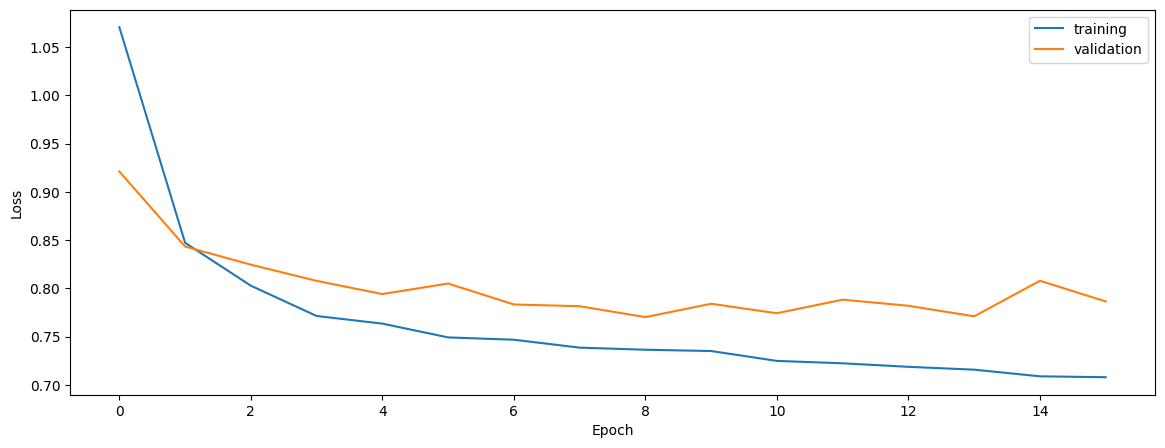

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.6843416660182807


0.6577698601630118


0.6595185581493532


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.6658857321187435


0.6201791711431254


0.6213948428313504


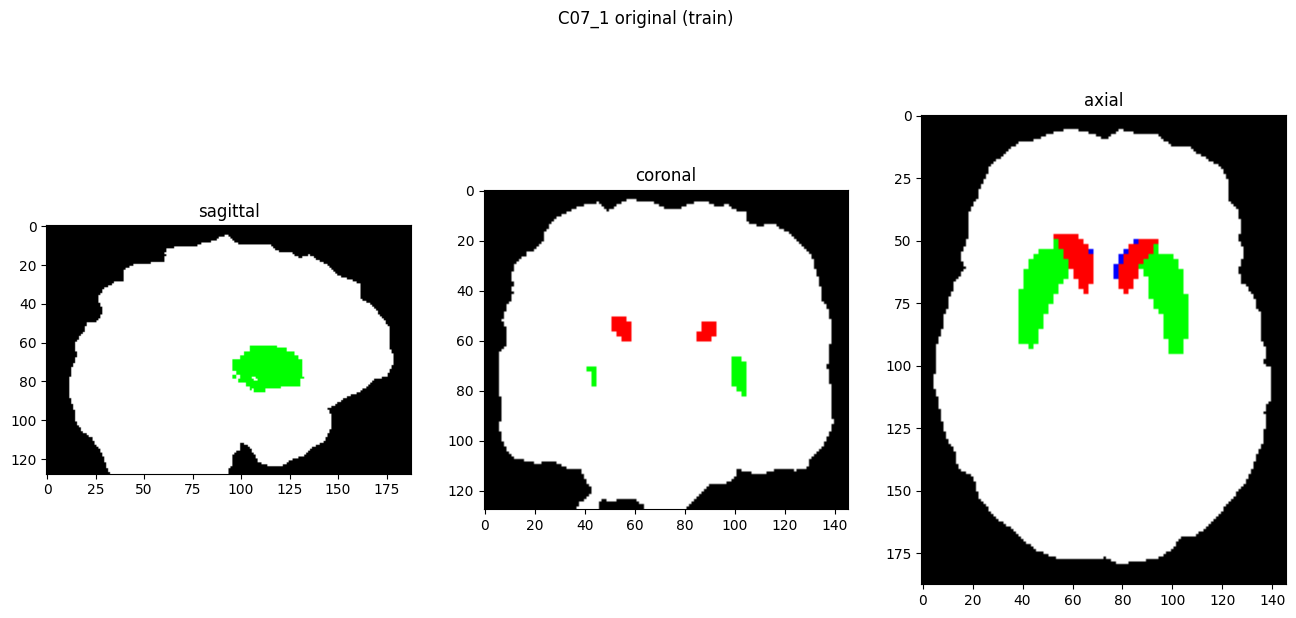

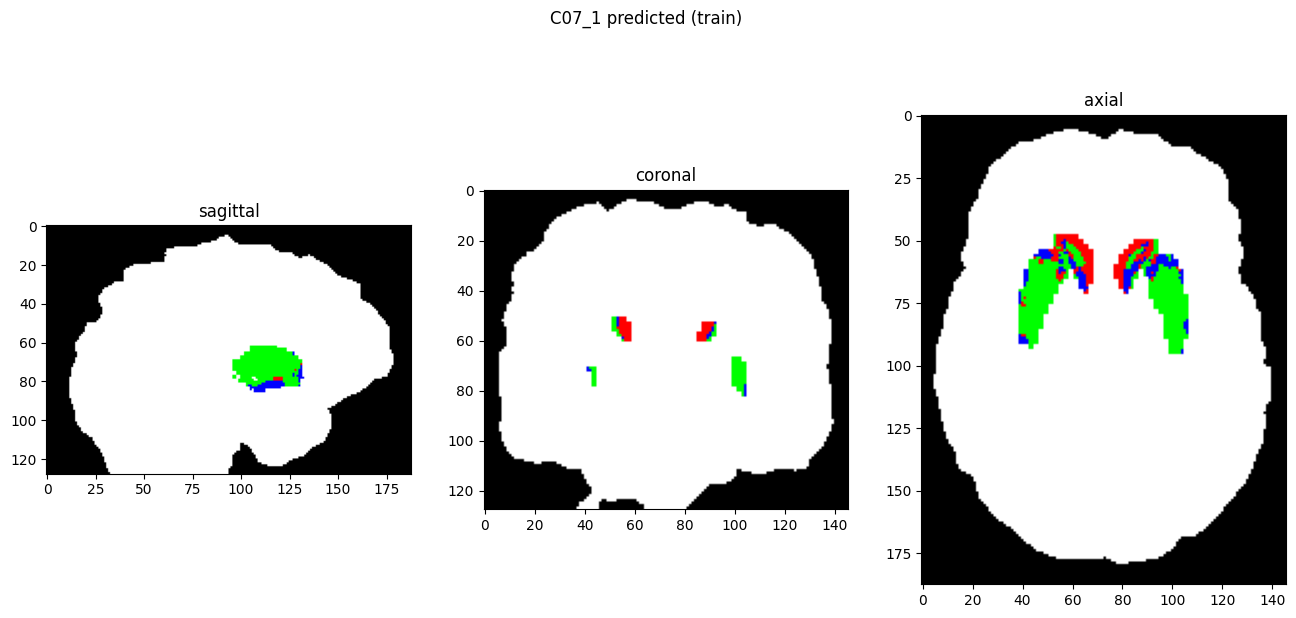

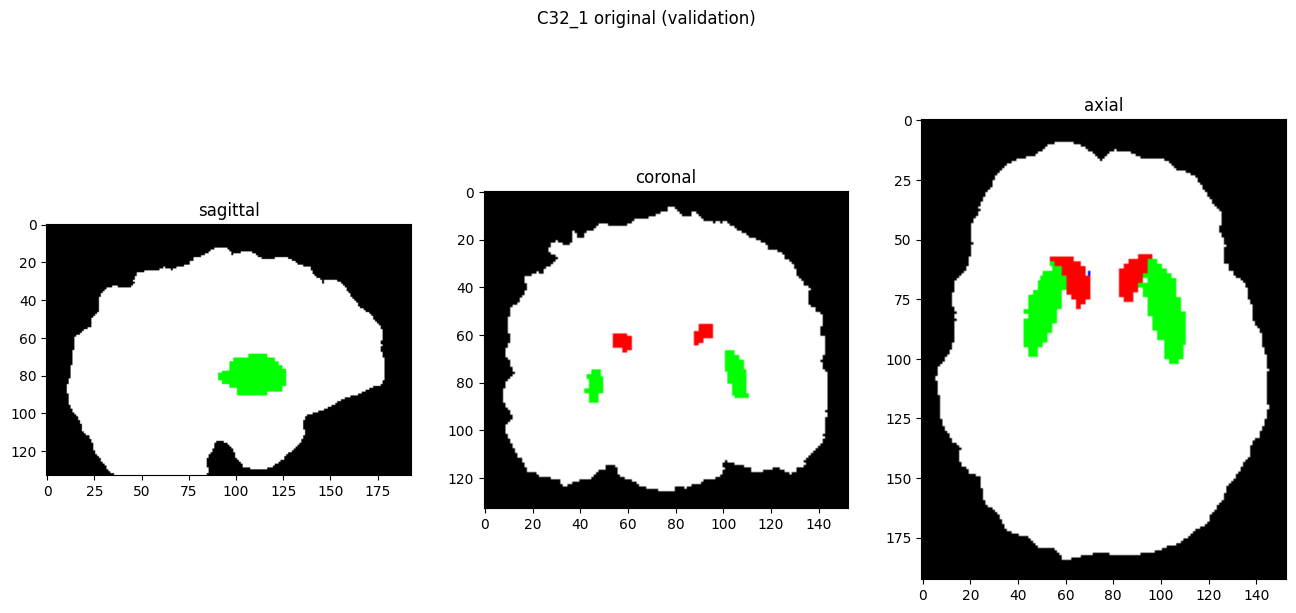

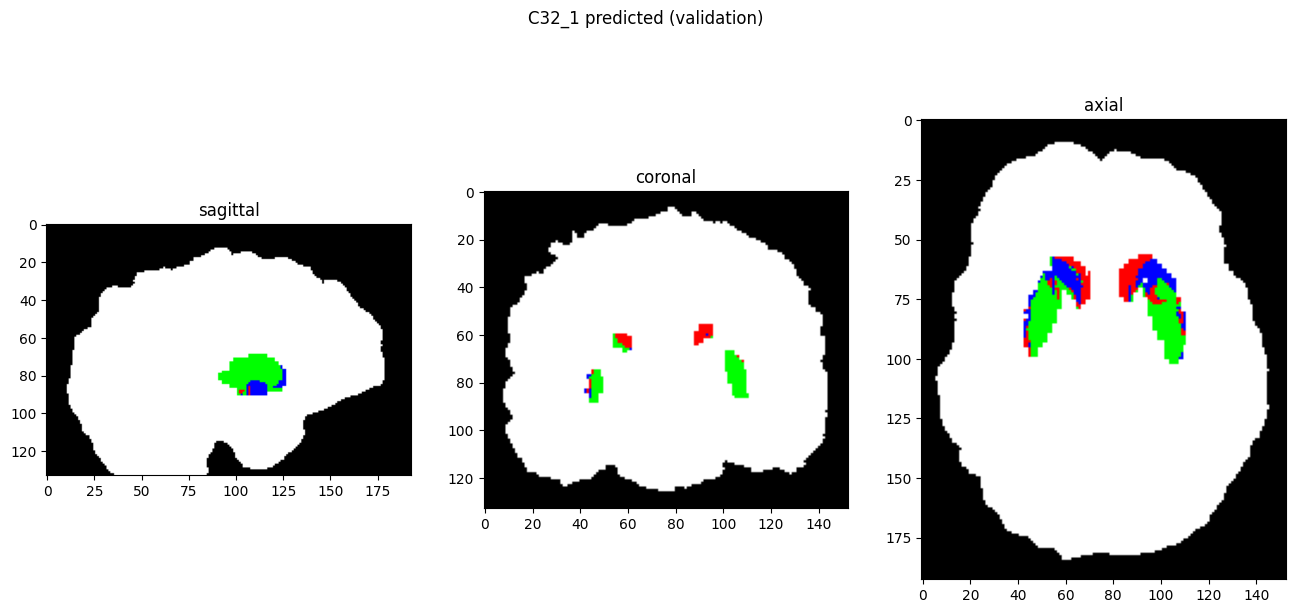

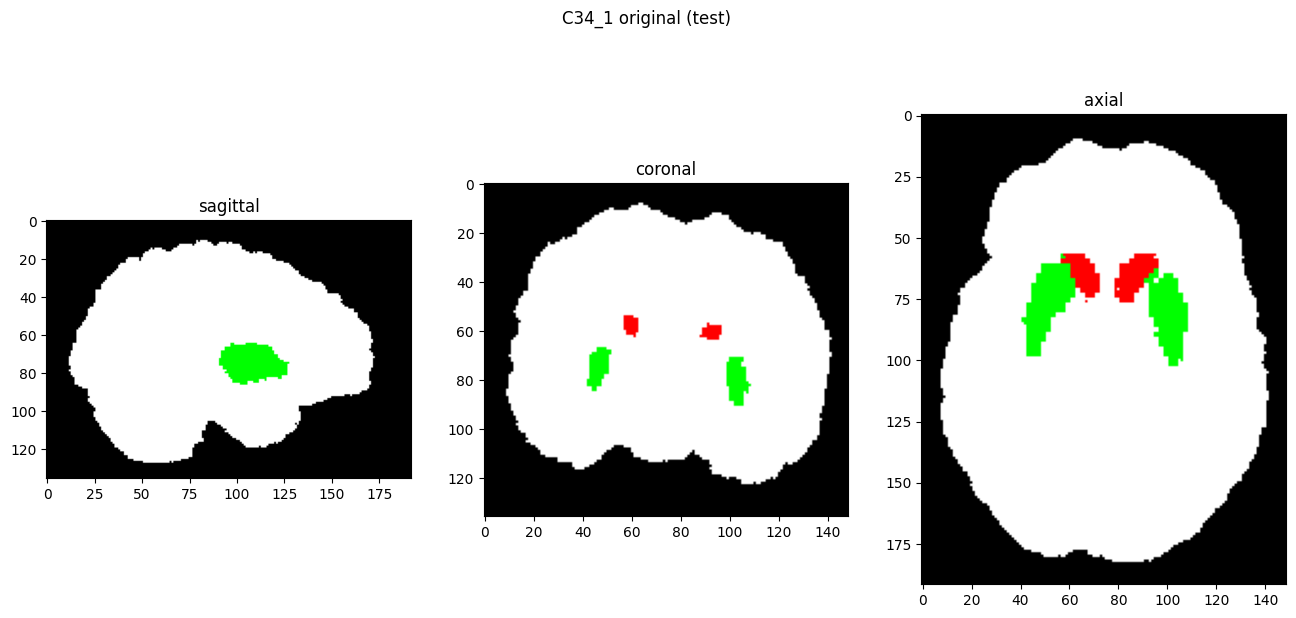

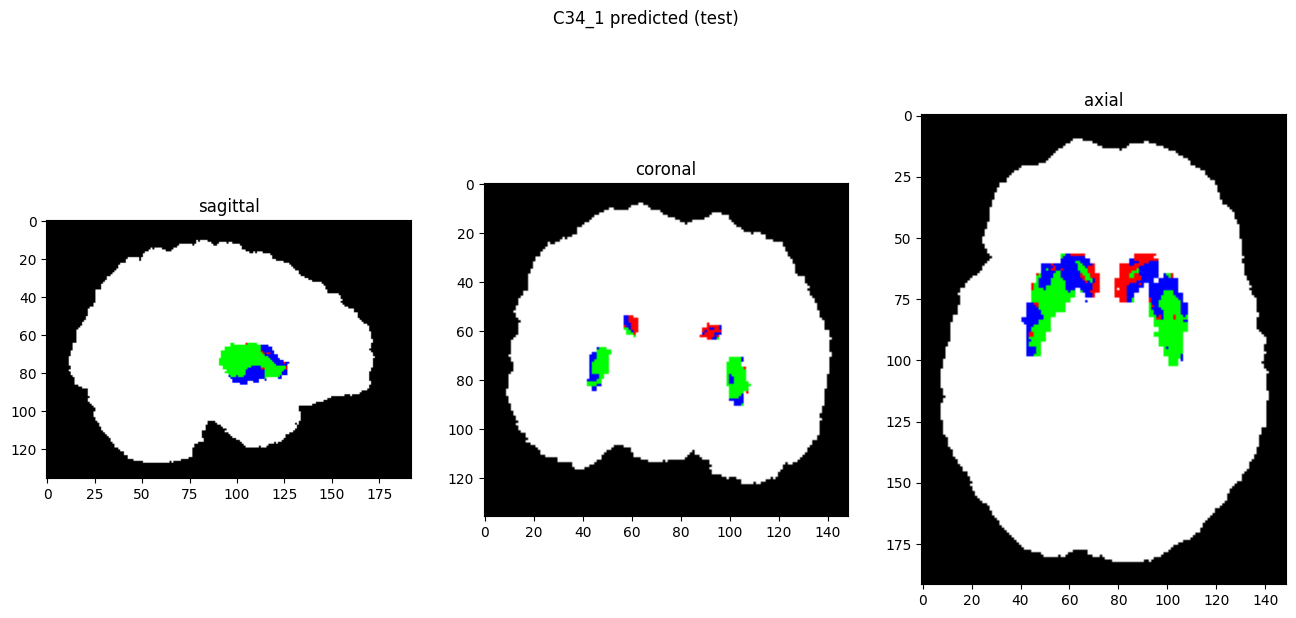

In [9]:
showResults(model, gen, threshold=0)